In [1]:
import numpy as np
import scipy.sparse as sparse
from os import listdir
import random
import matplotlib.pyplot as plt
from itertools import product, combinations, zip_longest
import cvxpy as cp
from collections import namedtuple

# Pull genotypes for a chromosome
m = 6
data_dir = '../split_gen_ihart'
#data_dir = '../split_gen_ihart_chip'
sample_file = '%s/chr.1.gen.samples.txt' % (data_dir)
ped_file = '../data/160826.ped'

In [2]:
# pull families with sequence data
with open(sample_file, 'r') as f:
    sample_id_to_index = dict([(line.strip(), i) for i, line in enumerate(f)])

# pull families from ped file
families = dict()
sample_id_to_sex = dict()
with open(ped_file, 'r') as f:	
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, f_id, m_id = pieces[0:4]

        if child_id in sample_id_to_index and f_id in sample_id_to_index and m_id in sample_id_to_index and 'LCL' not in child_id:
            if (fam_id, m_id, f_id) not in families:
                families[(fam_id, m_id, f_id)] = [m_id, f_id]
                sample_id_to_sex[m_id] = '2'
                sample_id_to_sex[f_id] = '1'
            families[(fam_id, m_id, f_id)].append(child_id)
            sample_id_to_sex[child_id] = pieces[4]
            
families_of_this_size = [(fkey, inds) for fkey, inds in families.items() if len(inds) == m]
print('families of size %d: %d' % (m, len(families_of_this_size)))

families of size 6: 57


# Look at one family

In [3]:
lcl_wb_inds = set(['AU1043304', 'AU2911309', 'AU1860301', 'AU3154301', 'AU3053301', 'AU3646301', 'AU3846302', 'AU3702307', 'AU3761302', 'AU3913302', 'AU3713302', 'AU3051303', 'AU3839303', 'AU4032306', 'AU2410302', 'AU1308303', 'AU4235303'])
families_of_this_size_with_lcl_wb_ind = [(fkey, inds) for fkey, inds in families_of_this_size if len(set(inds) & lcl_wb_inds) > 0]
print(len(families_of_this_size_with_lcl_wb_ind))


4


In [4]:
# WGS family: ('AU1163', 'AU1163202', 'AU1163201') ['AU1163202', 'AU1163201', 'AU1163302', 'AU1163303', 'AU1163304', 'AU1163305'] [1523, 1528, 1524, 1526, 1525, 1527]

# pick family
famkey, inds = random.choice(families_of_this_size_with_lcl_wb_ind)
lcl_wb_ind = list(set(inds) & lcl_wb_inds)[0]


indices = [sample_id_to_index[i] for i in inds] + [sample_id_to_index[lcl_wb_ind + '_LCL']]
print(famkey, inds, indices)



('AU3702', 'AU3702202', 'AU3702201') ['AU3702202', 'AU3702201', 'AU3702306', 'AU3702307', 'AU3702308', 'AU3702309'] [4093, 4586, 4190, 4191, 4194, 4193, 4192]


In [5]:
print([sample_id_to_sex[x] for x in inds])

['2', '1', '1', '2', '1', '1']


In [6]:
chroms = [str(x) for x in range(1, 23)]
all_gens = [None for _ in chroms]
all_positions = [None for _ in chroms]
num_calls = [None for _ in chroms]
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    try:
        gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

        # pull snp positions
        pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
        snp_positions = pos_data[:, 1]
        is_snp = pos_data[:, 2].astype(bool)

        # Pull data together
        A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[indices, :] for gen_file in gen_files])

        # filter out snps
        A = A[:, is_snp].A
        snp_positions = snp_positions[is_snp]
        num_calls[i] = snp_positions.shape[0]

        # don't need low coverage flag on missing values
        A[A<0] = -1

        # remove positions where whole family is missing or whole family is homref
        ok_indices = np.any(A>0, axis=0)
        A = A[:, ok_indices]
        snp_positions = snp_positions[ok_indices]

        print(A.shape)
        all_gens[i] = A
        all_positions[i] = snp_positions
    except Exception as e:
        print('Error')
        print(e)

1 (7, 419443)
2 (7, 417369)
3 (7, 352382)
4 (7, 370328)
5 (7, 304535)
6 (7, 340639)
7 (7, 307722)
8 (7, 266440)
9 Error
Bad CRC-32 for file 'data.npy'
10 (7, 261265)
11 (7, 256467)
12 (7, 238992)
13 Error
Bad CRC-32 for file 'data.npy'
14 Error
Bad CRC-32 for file 'data.npy'
15 Error
Bad CRC-32 for file 'data.npy'
16 Error
Bad CRC-32 for file 'data.npy'
17 Error
Bad CRC-32 for file 'data.npy'
18 Error
Bad CRC-32 for file 'indices.npy'
19 (7, 114382)
20 (7, 117999)
21 (7, 95020)
22 (7, 73894)


In [778]:
chrom = '2'
i = 1
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

# pull snp positions
pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
snp_positions = pos_data[:, 1]
is_snp = pos_data[:, 2].astype(bool)

# Pull data together
A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[indices, :] for gen_file in gen_files])

# filter out snps
A = A[:, is_snp].A
snp_positions = snp_positions[is_snp]
num_calls[i] = snp_positions.shape[0]

# don't need low coverage flag on missing values
A[A<0] = -1

# remove positions where whole family is missing or whole family is homref
ok_indices = np.any(A>0, axis=0)
A = A[:, ok_indices]
snp_positions = snp_positions[ok_indices]

print(A.shape)
all_gens[i] = A
all_positions[i] = snp_positions

(6, 417865)


# Poisson Regression

In [6]:
chrom_lengths = {
	'1': 225934550,
	'2': 238204522,
	'3': 194797140,
	'4': 188042934,
	'5': 177695260,
	'6': 167395067,
	'7': 155536559,
	'8': 142964911,
	'9': 120626573,
	'10': 131314747,
	'11': 131169619,
	'12': 130481395,
	'13': 95589878,
	'14': 88289540,
	'15': 81694769,
	'16': 78884753,
	'17': 78129607,
	'18': 74661510,
	'19': 56060841,
	'20': 59505520,
	'21': 35134224,
	'22': 34894566,
	'X': 151100560,
	'Y': 25653566
}

In [122]:
possible_genotypes_parents = [0, 1, 2, 3]
possible_genotypes_children = [0, 1, 2, 3]
possible_genotypes_famgen = [possible_genotypes_parents, possible_genotypes_parents] + [possible_genotypes_children]*(m-2)
all_famgens = list(product(*possible_genotypes_famgen))
#all_famgens = list(product(*[[0, 1, 2]]*m))
famgen_to_index = dict([(x, i) for i, x in enumerate(all_famgens)])
print('famgens', len(famgen_to_index))

famgens 4096


In [8]:
mendelian_trios = {
    (0, 0, 0), 
    (0, 1, 0), (0, 1, 1),
    (0, 2, 1),
    (1, 0, 0), (1, 0, 1),
    (1, 1, 0), (1, 1, 1), (1, 1, 2),
    (1, 2, 1), (1, 2, 2),
    (2, 0, 1),
    (2, 1, 1), (2, 1, 2),
    (2, 2, 2)
}

is_mendelian = np.ones(tuple(len(x) for x in possible_genotypes_famgen), dtype=bool)
for famgen in all_famgens:
    is_mend = True
    for j in range(2, m):
        if tuple([famgen[x] for x in [0, 1, j]]) not in mendelian_trios:
            is_mend = False
    is_mendelian[famgen] = is_mend
print('Mendelian', np.sum(is_mendelian), 'Nonmendelian', np.sum(~is_mendelian))
print(is_mendelian.shape)



Mendelian 149 Nonmendelian 580
(3, 3, 3, 3, 3, 3)


In [100]:
from collections import defaultdict

nonmendelian_famgens = list(zip(*np.where(~is_mendelian)))
mendelian_famgens = list(zip(*np.where(is_mendelian)))

nm_famgen_to_index = dict([(x, i) for i, x in enumerate(nonmendelian_famgens)])

transition_to_fg_pairs = defaultdict(list)
for nmfg in nonmendelian_famgens:
    for mfg in mendelian_famgens:
        new_transition = tuple([(j, b, a) for j, (a, b) in enumerate(zip(nmfg, mfg)) if a != b])
        
        if len(new_transition) <= 2:
            transition_to_fg_pairs[new_transition].append((nmfg, mfg))

        
all_transitions = sorted(transition_to_fg_pairs.keys())
print('transitions', len(all_transitions))
is_one_step = np.asarray([len(t)==1 for t in all_transitions])
print('one step', np.sum(is_one_step))
transition_to_index = dict([(x, i) for i, x in enumerate(all_transitions)])

from collections import Counter
print(len(all_transitions))
print(Counter([len(x) for x in transition_to_fg_pairs]))
print(Counter([len(x) for x in transition_to_fg_pairs.values()]))

#all_transitions = [k for k in all_transitions if len(k)==1]
#transition_to_fg_pairs = dict([(k, transition_to_fg_pairs[k]) for k in all_transitions])
#print('transitions', len(all_transitions))
#is_one_step = np.asarray([len(t)==1 for t in all_transitions])
#print('one step', np.sum(is_one_step))
#transition_to_index = dict([(x, i) for i, x in enumerate(all_transitions)])

transitions 390
one step 32
390
Counter({2: 358, 1: 32})
Counter({8: 120, 1: 58, 9: 52, 27: 32, 18: 20, 34: 16, 35: 16, 43: 16, 26: 16, 17: 12, 10: 12, 15: 8, 95: 4, 80: 4, 16: 4})


In [101]:
from collections import defaultdict

nonmendelian_famgens = list(zip(*np.where(~is_mendelian)))
mendelian_famgens = list(zip(*np.where(is_mendelian)))

nm_famgen_to_index = dict([(x, i) for i, x in enumerate(nonmendelian_famgens)])

transition_to_fg_pairs = defaultdict(list)
for nmfg in nonmendelian_famgens:
    if np.all([x<=2 for x in nmfg]):
        for j in range(m):
            for i in range(len(possible_genotypes_famgen[j])):
                mfg = tuple(i if k==j else nmfg[k] for k in range(m))
                if is_mendelian[mfg]:
                    new_transition = tuple([(j, b, a) for j, (a, b) in enumerate(zip(nmfg, mfg)) if a != b])
                    transition_to_fg_pairs[new_transition].append((nmfg, mfg))
        
all_transitions = sorted(transition_to_fg_pairs.keys())
print('transitions', len(all_transitions))
is_one_step = np.asarray([len(t)==1 for t in all_transitions])
print('one step', np.sum(is_one_step))
transition_to_index = dict([(x, i) for i, x in enumerate(all_transitions)])

transitions 32
one step 32


In [51]:
#print('\n'.join(['%s\n%s' % (k, v) for k, v in transition_to_fg_pairs.items() if k[0][1]>2 or k[0][2]>2]))
print(all_transitions)

[((0, 0, 2),), ((0, 1, 0),), ((0, 1, 2),), ((0, 2, 0),), ((1, 0, 2),), ((1, 1, 0),), ((1, 1, 2),), ((1, 2, 0),), ((2, 0, 1),), ((2, 0, 2),), ((2, 1, 0),), ((2, 1, 2),), ((2, 2, 0),), ((2, 2, 1),), ((3, 0, 1),), ((3, 0, 2),), ((3, 1, 0),), ((3, 1, 2),), ((3, 2, 0),), ((3, 2, 1),), ((4, 0, 1),), ((4, 0, 2),), ((4, 1, 0),), ((4, 1, 2),), ((4, 2, 0),), ((4, 2, 1),), ((5, 0, 1),), ((5, 0, 2),), ((5, 1, 0),), ((5, 1, 2),), ((5, 2, 0),), ((5, 2, 1),)]


In [92]:
def build_X_and_y(chrom, family_genotypes_for_chrom, num_calls):
    unique_gens, counts = np.unique(family_genotypes_for_chrom, return_counts=True, axis=1)

    # fill in genotype_to_counts
    genotype_to_counts = np.zeros(tuple([3]*m), dtype=int)
    ref_counts = 0
    for g, c in zip(unique_gens.T, counts):
        if tuple(g) in famgen_to_index:
            genotype_to_counts[tuple(g)] = c
            
            if tuple(g) == tuple([0]*m):
                ref_counts = c

    genotype_to_counts[tuple([0]*m)] = num_calls - family_genotypes_for_chrom.shape[1] + ref_counts

    # form X
    X = np.zeros((len(nonmendelian_famgens), len(all_transitions)))

    
    for trans, fg_pairs in transition_to_fg_pairs.items():
        trans_index = transition_to_index[trans]
        for famgen, neighbor in fg_pairs:
            famgen_index = nm_famgen_to_index[famgen]
            # X[i, j] = max(0, genotype_to_counts[neighbor])/np.sum((genotype_to_counts*is_mendelian)[tuple(trans[1] if k==trans[0] else slice(None, None, None) for k in range(m))])
            
            slice_def = tuple(slice(None, None, None) if a==b else b for a, b in zip(famgen, neighbor))
            X[famgen_index, trans_index] = genotype_to_counts[neighbor]/np.sum((genotype_to_counts*is_mendelian)[slice_def])

        # hard to sequence error
        #one_indices = [k for k, x in enumerate(famgen) if x == 1]
        #for replacements in product([0, 1, 2], repeat=len(one_indices)):
        #    neighbor = np.asarray(famgen)
        #    neighbor[one_indices] = replacements
        #    neighbor = tuple(neighbor)
        #
        #    if is_mendelian[neighbor]:
        #        X[i, -1] += genotype_to_counts[neighbor]/hard_to_seq_norm

    y = np.asarray([genotype_to_counts[x] for x in nonmendelian_famgens])

    print('zeros rows:', np.sum(np.sum(X, axis=1)==0), 'cols:', np.sum(np.sum(X, axis=0)==0))
    indices = np.where(np.sum(X, axis=1) != 0)[0]
    unused_famgens = [nonmendelian_famgens[i] for i in range(len(nonmendelian_famgens)) if i not in indices]
    X = X[indices, :]
    y = y[indices]
    nm = [nonmendelian_famgens[i] for i in indices]
    
    
    return X, y, nm, genotype_to_counts
    

In [93]:
def build_genome_X_and_y(chroms, family_genotypes_for_chroms, num_calls):
    genotype_to_counts = np.zeros(tuple(len(x) for x in possible_genotypes_famgen), dtype=int)
    
    for chrom, family_genotypes_for_chrom, nc in zip(chroms, family_genotypes_for_chroms, num_calls):
        unique_gens, counts = np.unique(family_genotypes_for_chrom, return_counts=True, axis=1)

        # fill in genotype_to_counts
        ref_counts = 0
        for g, c in zip(unique_gens.T, counts):
            if tuple(g) in famgen_to_index:
                genotype_to_counts[tuple(g)] += c
                
                if tuple(g) == tuple([0]*m):
                    ref_counts = c

        genotype_to_counts[tuple([0]*m)] += (nc - family_genotypes_for_chrom.shape[1]) + ref_counts

    # form X
    X = np.zeros((len(nonmendelian_famgens), len(all_transitions)))
    
    for trans, fg_pairs in transition_to_fg_pairs.items():
        trans_index = transition_to_index[trans]
        for famgen, neighbor in fg_pairs: # nmfg, mfg
            famgen_index = nm_famgen_to_index[famgen]
            
            if genotype_to_counts[neighbor]>0:
                slice_def = tuple(slice(None, None, None) if a==b else b for a, b in zip(famgen, neighbor))
                X[famgen_index, trans_index] = genotype_to_counts[neighbor]/np.sum((genotype_to_counts*is_mendelian)[slice_def])
                
    y = np.asarray([genotype_to_counts[x] for x in nonmendelian_famgens])

    print('zeros rows:', np.sum(np.sum(X, axis=1)==0), 'cols:', np.sum(np.sum(X, axis=0)==0))
    indices = np.where(np.sum(X, axis=1) != 0)[0]
    unused_famgens = [nonmendelian_famgens[i] for i in range(len(nonmendelian_famgens)) if i not in indices]
    X = X[indices, :]
    y = y[indices]
    nm = [nonmendelian_famgens[i] for i in indices]
    
    
    return X, y, nm, genotype_to_counts, unused_famgens
    

In [102]:
def estimate_family_error(X, y, all_transitions):
    
    old_trans_index_to_new_trans_index = dict()
    
    new_transitions = []
    #for j, s, e in set([(t[0][0], t[0][1], t[0][2]) for t in all_transitions if len(t)==1]):
    #    ts = [i for i, t in enumerate(all_transitions) if len(t) == 1 and t[0][0] == j and t[0][1] == s and t[0][2] == e]
    #    for t in ts:
    #        old_trans_index_to_new_trans_index[t] = len(new_transitions)  
    #    new_transitions.append((j, s, e))
    
    for s1, e1 in set([t[0][1:] for t in all_transitions if len(t)==1]):
        ts = [i for i, t in enumerate(all_transitions) if len(t) == 1 and t[0][1] == s1 and t[0][2] == e1]
        for t in ts:
            old_trans_index_to_new_trans_index[t] = len(new_transitions)  
        new_transitions.append((s1, e1))
        
    for s1, e1, s2, e2 in set([(t[0][1], t[0][2], t[1][1], t[1][2]) for t in all_transitions if len(t)==2]):
        ts = [i for i, t in enumerate(all_transitions) if len(t) == 2 and t[0][1] == s1 and t[0][2] == e1 and t[1][1] == s2 and t[1][2] == e2]
        for t in ts:
            old_trans_index_to_new_trans_index[t] = len(new_transitions)  
        new_transitions.append((s1, e1, s2, e2))
           
    for s1, e1, s2, e2, s3, e3 in set([(t[0][1], t[0][2], t[1][1], t[1][2], t[2][1], t[2][2]) for t in all_transitions if len(t)==3]):
        ts = [i for i, t in enumerate(all_transitions) if len(t) == 3 and t[0][1] == s1 and t[0][2] == e1 and t[1][1] == s2 and t[1][2] == e2 and t[2][1] == s3 and t[2][2] == e3]
        for t in ts:
            old_trans_index_to_new_trans_index[t] = len(new_transitions)
        new_transitions.append((s1, e1, s2, e2, s3, e3))
            
    newX = np.zeros((X.shape[0], len(new_transitions)))
    for old_trans_index, new_trans_index in old_trans_index_to_new_trans_index.items():
        newX[:, new_trans_index] += X[:, old_trans_index]
        
    print(newX.shape)
    
    # cvxpy
    n = cp.Variable(newX.shape[1])

    #objective = cp.Minimize(cp.norm(X*n - y, 2)**2)  
    #prob = cp.Problem(objective, [0 <= n])
    
    mu = np.sum(newX, axis=0)
    objective = cp.Minimize(mu*n - y*cp.log(newX*n))
    constraints = [n>=0, newX[y>0, :]*n <= y[y>0]]
    
    prob = cp.Problem(objective, constraints)
    
    result = prob.solve(solver='ECOS', max_iters=1000)
    print(prob.status)
    
    n = np.asarray([v[0, 0] for v in n.value])
    n = [n[old_trans_index_to_new_trans_index[i]] for i in range(len(old_trans_index_to_new_trans_index))]
    
    return prob.status, n, X.dot(n), y

            


In [103]:
print(all_transitions[0:10])

[((0, 0, 2),), ((0, 1, 0),), ((0, 1, 2),), ((0, 2, 0),), ((1, 0, 2),), ((1, 1, 0),), ((1, 1, 2),), ((1, 2, 0),), ((2, 0, 1),), ((2, 0, 2),)]


In [104]:
#X_genome, y_genome, nm_genome, genotype_to_counts_genome = build_genome_X_and_y(chroms, all_gens, num_calls=num_calls)

#X_genome, y_genome, nm_genome, genotype_to_counts_genome = build_genome_X_and_y(chroms, all_gens)

#X_genome, y_genome, nm_genome, genotype_to_counts_genome, unused_famgens_genome = build_genome_X_and_y(chroms, all_gens_chip, num_calls_chip)


In [105]:
wb_indices = list(range(m))
print(wb_indices)

X_genome, y_genome, nm_genome, genotype_to_counts_genome, unused_famgens_genome = build_genome_X_and_y(chroms, [x[wb_indices, :] for x in all_gens], [chrom_lengths[chrom] for chrom in chroms])
print('Percent mendelian', np.sum(genotype_to_counts_genome*is_mendelian)/np.sum(genotype_to_counts_genome))

prob_status, n_genome_wb, expected_genome_wb, observed_genome_wb = estimate_family_error(X_genome, y_genome, all_transitions)

lcl_indices = list(range(m))
lcl_wb_index = inds.index(lcl_wb_ind)
lcl_indices[lcl_wb_index] = -1
print(lcl_indices)

X_genome, y_genome, nm_genome, genotype_to_counts_genome, unused_famgens_genome = build_genome_X_and_y(chroms, [x[lcl_indices, :] for x in all_gens], [chrom_lengths[chrom] for chrom in chroms])
print('Percent mendelian', np.sum(genotype_to_counts_genome*is_mendelian)/np.sum(genotype_to_counts_genome))

prob_status, n_genome_lcl, expected_genome_lcl, observed_genome_lcl = estimate_family_error(X_genome, y_genome, all_transitions)


[0, 1, 2, 3, 4, 5]
zeros rows: 222 cols: 0
Percent mendelian 0.999935279712
(358, 6)
optimal
[0, 1, 2, 3, -1, 5]
zeros rows: 222 cols: 0
Percent mendelian 0.999936879781
(358, 6)
optimal


In [112]:
ns_wb, expecteds_wb, observeds_wb = [None]*len(chroms), [None]*len(chroms), [None]*len(chroms)
genotypes_wb = [None]*len(chroms)
ns_lcl, expecteds_lcl, observeds_lcl = [None]*len(chroms), [None]*len(chroms), [None]*len(chroms)
genotypes_lcl = [None]*len(chroms)

for i in range(len(chroms)):
    try:
        chrom = chroms[i]
        X, y, nm, genotype_to_counts = build_X_and_y(chrom, all_gens[i][wb_indices, :], chrom_lengths[chrom])
        prob_status, n, expected, observed = estimate_family_error(X, y, all_transitions)
        if 'optimal' in prob_status:
            ns_wb[i] = n
            expecteds_wb[i] = expected
            observeds_wb[i] = observed
            genotypes_wb[i] = genotype_to_counts
            
        X, y, nm, genotype_to_counts = build_X_and_y(chrom, all_gens[i][lcl_indices, :], chrom_lengths[chrom])
        prob_status, n, expected, observed = estimate_family_error(X, y, all_transitions)
        if 'optimal' in prob_status:
            ns_lcl[i] = n
            expecteds_lcl[i] = expected
            observeds_lcl[i] = observed
            genotypes_lcl[i] = genotype_to_counts
            
    except Exception as e:
        print('Error')
        print(prob_status)
        print(e)

zeros rows: 226 cols: 0
(354, 6)
optimal
zeros rows: 236 cols: 0
(344, 6)
optimal
zeros rows: 228 cols: 0
(352, 6)
optimal
zeros rows: 232 cols: 0
(348, 6)
optimal
zeros rows: 248 cols: 0
(332, 6)
optimal
zeros rows: 248 cols: 0
(332, 6)
optimal
zeros rows: 230 cols: 0
(350, 6)
optimal
zeros rows: 226 cols: 0
(354, 6)
optimal
zeros rows: 244 cols: 0
(336, 6)
optimal
zeros rows: 254 cols: 0
(326, 6)
optimal
zeros rows: 246 cols: 0
(334, 6)
optimal
zeros rows: 248 cols: 0
(332, 6)
optimal
zeros rows: 246 cols: 0
(334, 6)
optimal
zeros rows: 246 cols: 0
(334, 6)
optimal
zeros rows: 277 cols: 0
(303, 6)
optimal
zeros rows: 270 cols: 0
(310, 6)
optimal
zeros rows: 238 cols: 0
(342, 6)
optimal
zeros rows: 244 cols: 0
(336, 6)
optimal
zeros rows: 250 cols: 0
(330, 6)
optimal
zeros rows: 250 cols: 0
(330, 6)
optimal
zeros rows: 260 cols: 0
(320, 6)
optimal
zeros rows: 258 cols: 0
(322, 6)
optimal
zeros rows: 250 cols: 0
(330, 6)
optimal
zeros rows: 260 cols: 0
(320, 6)
optimal
zeros rows: 265 

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


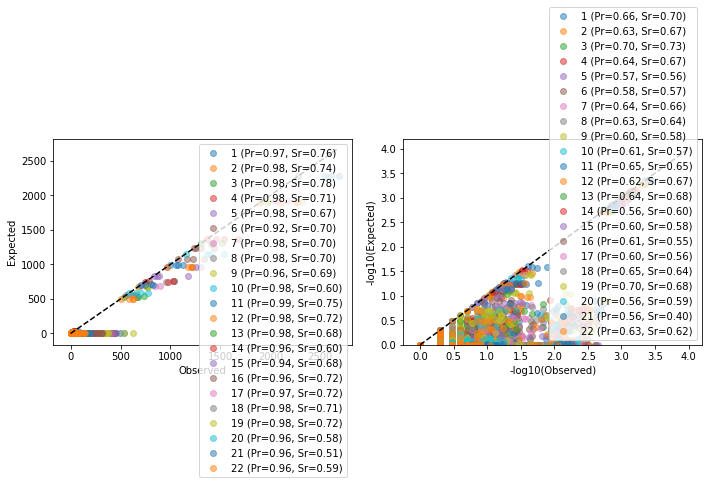

In [113]:
import scipy.stats.stats as stats

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

for i in range(len(chroms)):
    pearsonr = stats.pearsonr(observeds_wb[i], expecteds_wb[i])[0]
    spearmanr = stats.spearmanr(observeds_wb[i], expecteds_wb[i])[0]
    plt.scatter(observeds_wb[i], expecteds_wb[i], label='%s (Pr=%0.2f, Sr=%0.2f)' % (chroms[i], pearsonr, spearmanr), alpha=0.5)

max_value = max([np.max(x) for x in observeds_wb if x is not None])
plt.plot([0, max_value], [0, max_value], linestyle='--', color='black')
plt.xlabel('Observed')
plt.ylabel('Expected')
plt.legend()

plt.subplot(1, 2, 2)

for i in range(len(chroms)):
    indices = observeds_wb[i] != 0
    pearsonr = stats.pearsonr(np.log10(observeds_wb[i][indices]), np.log10(expecteds_wb[i][indices]))[0]
    spearmanr = stats.spearmanr(np.log10(observeds_wb[i][indices]), np.log10(expecteds_wb[i][indices]))[0]
    plt.scatter(np.log10(observeds_wb[i][indices]), np.clip(np.log10(expecteds_wb[i][indices]), 0, None), label='%s (Pr=%0.2f, Sr=%0.2f)' % (chroms[i], pearsonr, spearmanr), alpha=0.5)
        
max_value = np.ceil(max([np.max(np.log10(x)) for x in observeds_wb if x is not None]))
plt.plot([0, max_value], [0, max_value], linestyle='--', color='black')
plt.xlabel('-log10(Observed)')
plt.ylabel('-log10(Expected)')
plt.ylim([0, None])
plt.legend()

plt.tight_layout()
plt.show()

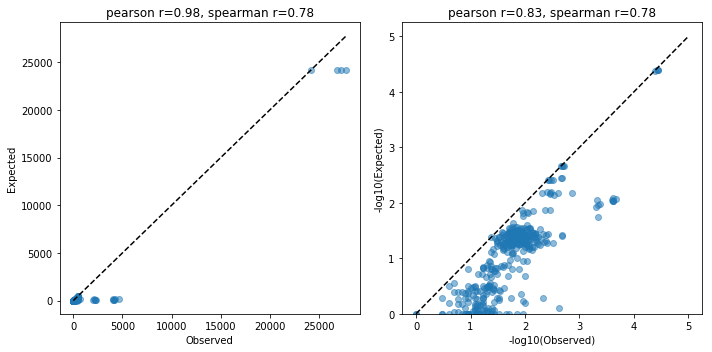

In [114]:
import scipy.stats.stats as stats

plt.figure(figsize=(1, 5))
plt.subplot(1, 2, 1)

pearsonr = stats.pearsonr(observed_genome_wb, expected_genome_wb)[0]
spearmanr = stats.spearmanr(observed_genome_wb, expected_genome_wb)[0]

plt.scatter(observed_genome_wb, expected_genome_wb, alpha=0.5)

plt.title('pearson r=%0.2f, spearman r=%0.2f' % (pearsonr, spearmanr))
max_value = np.max(observed_genome_wb)
plt.plot([0, max_value], [0, max_value], linestyle='--', color='black')
plt.xlabel('Observed')
plt.ylabel('Expected')

plt.subplot(1, 2, 2)

indices = observed_genome_wb != 0
pearsonr = stats.pearsonr(np.log10(observed_genome_wb[indices]), np.clip(np.log10(expected_genome_wb[indices]), 0, None))[0]
spearmanr = stats.spearmanr(np.log10(observed_genome_wb[indices]), np.clip(np.log10(expected_genome_wb[indices]), 0, None))[0]
plt.title('pearson r=%0.2f, spearman r=%0.2f' % (pearsonr, spearmanr))

plt.scatter(np.log10(observed_genome_wb[indices]), np.clip(np.log10(expected_genome_wb[indices]), 0, None), alpha=0.5)
        
max_value = np.ceil(np.max(np.log10(observed_genome_wb)))
plt.plot([0, max_value], [0, max_value], linestyle='--', color='black')
plt.xlabel('-log10(Observed)')
plt.ylabel('-log10(Expected)')
plt.ylim([0, None])


plt.tight_layout()
plt.show()

In [115]:
higher_order_type_to_index = dict()
for i, trans in enumerate(all_transitions):
    if len(trans)>1:
        higher_order_type_to_index[tuple(sorted([t[1:] for t in trans]))] = i

for e in higher_order_type_to_index:
    if n_genome_wb[higher_order_type_to_index[e]] > 1:
        print(int(n_genome_wb[higher_order_type_to_index[e]]), '\t', e)

In [116]:
error_types = [(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]
error_type_to_index = dict([(x, i) for i, x in enumerate(error_types)])

errors_wb = np.zeros((len(error_types), m, len(chroms)))
errors_genome_wb = np.zeros((len(error_types), m))
errors_lcl = np.zeros((len(error_types), m, len(chroms)))
errors_genome_lcl = np.zeros((len(error_types), m))


# Genome WB
for trans, n in zip(all_transitions, n_genome_wb):
    if len(trans) == 1:
        for t in trans:
            errors_genome_wb[error_type_to_index[tuple(t[1:])], t[0]] += n
            
    # estimate parental 0->1 and 2->1 errors
    errors_genome_wb[0, :2] = np.mean(errors_genome_wb[0, 2:])
    errors_genome_wb[5, :2] = np.mean(errors_genome_wb[5, 2:])
    
# now fill in second order errors
for e1, e2 in product(error_types, repeat=2):
    e = tuple(sorted([e1, e2]))
    if e in higher_order_type_to_index:
        errors_genome_wb[error_type_to_index[e1], :] += n_genome_wb[higher_order_type_to_index[e]]
        errors_genome_wb[error_type_to_index[e2], :] += n_genome_wb[higher_order_type_to_index[e]]
        
# now fill in third order errors
for e1, e2, e3 in product(error_types, repeat=3):
    e = tuple(sorted([e1, e2, e3]))
    if e in higher_order_type_to_index:
        errors_genome_wb[error_type_to_index[e1], :] += n_genome_wb[higher_order_type_to_index[e]]
        errors_genome_wb[error_type_to_index[e2], :] += n_genome_wb[higher_order_type_to_index[e]]
        errors_genome_wb[error_type_to_index[e3], :] += n_genome_wb[higher_order_type_to_index[e]]
        
# Genome LCL
for trans, n in zip(all_transitions, n_genome_lcl):
    if len(trans) == 1:
        for t in trans:
            errors_genome_lcl[error_type_to_index[tuple(t[1:])], t[0]] += n
            
    # estimate parental 0->1 and 2->1 errors
    errors_genome_lcl[0, :2] = np.mean(errors_genome_lcl[0, 2:])
    errors_genome_lcl[5, :2] = np.mean(errors_genome_lcl[5, 2:])
    
# now fill in second order errors
for e1, e2 in product(error_types, repeat=2):
    e = tuple(sorted([e1, e2]))
    if e in higher_order_type_to_index:
        errors_genome_lcl[error_type_to_index[e1], :] += n_genome_lcl[higher_order_type_to_index[e]]
        errors_genome_lcl[error_type_to_index[e2], :] += n_genome_lcl[higher_order_type_to_index[e]]
        
# now fill in third order errors
for e1, e2, e3 in product(error_types, repeat=3):
    e = tuple(sorted([e1, e2, e3]))
    if e in higher_order_type_to_index:
        errors_genome_lcl[error_type_to_index[e1], :] += n_genome_lcl[higher_order_type_to_index[e]]
        errors_genome_lcl[error_type_to_index[e2], :] += n_genome_lcl[higher_order_type_to_index[e]]
        errors_genome_lcl[error_type_to_index[e3], :] += n_genome_lcl[higher_order_type_to_index[e]]
        
for j in range(len(chroms)):
    if ns_wb[j] is not None and ns_lcl[j] is not None:
        for trans, n_wb, n_lcl in zip(all_transitions, ns_wb[j], ns_lcl[j]):
            if len(trans) == 1:
                for t in trans:
                    errors_wb[error_type_to_index[tuple(t[1:])], t[0], j] += n_wb
                    errors_lcl[error_type_to_index[tuple(t[1:])], t[0], j] += n_lcl

            # estimate parental 0->1 and 2->1 errors
            errors_wb[0, :2, j] = np.mean(errors_wb[0, 2:, j])
            errors_wb[5, :2, j] = np.mean(errors_wb[5, 2:, j])
            errors_lcl[0, :2, j] = np.mean(errors_lcl[0, 2:, j])
            errors_lcl[5, :2, j] = np.mean(errors_lcl[5, 2:, j])

        # now fill in second order errors
        for e1, e2 in product(error_types, repeat=2):
            e = tuple(sorted([e1, e2]))
            if e in higher_order_type_to_index:
                errors_wb[error_type_to_index[e1], :, j] += ns_wb[j][higher_order_type_to_index[e]]
                errors_wb[error_type_to_index[e2], :, j] += ns_wb[j][higher_order_type_to_index[e]]
                errors_lcl[error_type_to_index[e1], :, j] += ns_lcl[j][higher_order_type_to_index[e]]
                errors_lcl[error_type_to_index[e2], :, j] += ns_lcl[j][higher_order_type_to_index[e]]

        # now fill in third order errors
        for e1, e2, e3 in product(error_types, repeat=3):
            e = tuple(sorted([e1, e2, e3]))
            if e in higher_order_type_to_index:
                errors_wb[error_type_to_index[e1], :, j] += ns_wb[j][higher_order_type_to_index[e]]
                errors_wb[error_type_to_index[e2], :, j] += ns_wb[j][higher_order_type_to_index[e]]
                errors_wb[error_type_to_index[e3], :, j] += ns_wb[j][higher_order_type_to_index[e]]
                errors_lcl[error_type_to_index[e1], :, j] += ns_lcl[j][higher_order_type_to_index[e]]
                errors_lcl[error_type_to_index[e2], :, j] += ns_lcl[j][higher_order_type_to_index[e]]
                errors_lcl[error_type_to_index[e3], :, j] += ns_lcl[j][higher_order_type_to_index[e]]

In [117]:
print(errors_genome_wb)
print(errors_wb[0, :, 0])
print(errors_lcl[0, :, 0])

[[  2.41234890e+04   2.41234890e+04   2.41234890e+04   2.41234890e+04
    2.41234890e+04   2.41234890e+04]
 [  2.60122091e+02   2.60122091e+02   2.60122091e+02   2.60122091e+02
    2.60122091e+02   2.60122091e+02]
 [  1.76885253e+03   1.76885253e+03   1.76885253e+03   1.76885253e+03
    1.76885253e+03   1.76885253e+03]
 [  6.78832884e+02   6.78832884e+02   6.78832884e+02   6.78832884e+02
    6.78832884e+02   6.78832884e+02]
 [  1.98635862e+00   1.98635862e+00   1.98635862e+00   1.98635862e+00
    1.98635862e+00   1.98635862e+00]
 [  7.69640761e+02   7.69640761e+02   7.69640761e+02   7.69640761e+02
    7.69640761e+02   7.69640761e+02]]
[ 2277.85665533  2277.85665533  2277.85665533  2277.85665533  2277.85665533
  2277.85665533]
[ 2333.06724943  2333.06724943  2333.06724943  2333.06724943  2333.06724943
  2333.06724943]


In [118]:
f = np.sum(observed_genome_wb-expected_genome_wb)/np.sum(observed_genome_wb)
print('Fraction unexplained non-mendelian', f)
print(np.sum(observed_genome_wb-expected_genome_wb))
      
print()
print('% of errors that appear non-mendelian', np.sum(genotype_to_counts_genome[~is_mendelian])/np.sum(errors_genome_wb))    

print("Errors that we can't detect via simple family mendelian check", (1-(np.sum(genotype_to_counts_genome[~is_mendelian])/np.sum(errors_genome_wb)))*np.sum(errors_genome_wb))
                                                                                 

Fraction unexplained non-mendelian 0.366462480505
62295.6899861

% of errors that appear non-mendelian 1.02405818994
Errors that we can't detect via simple family mendelian check -3984.45827672


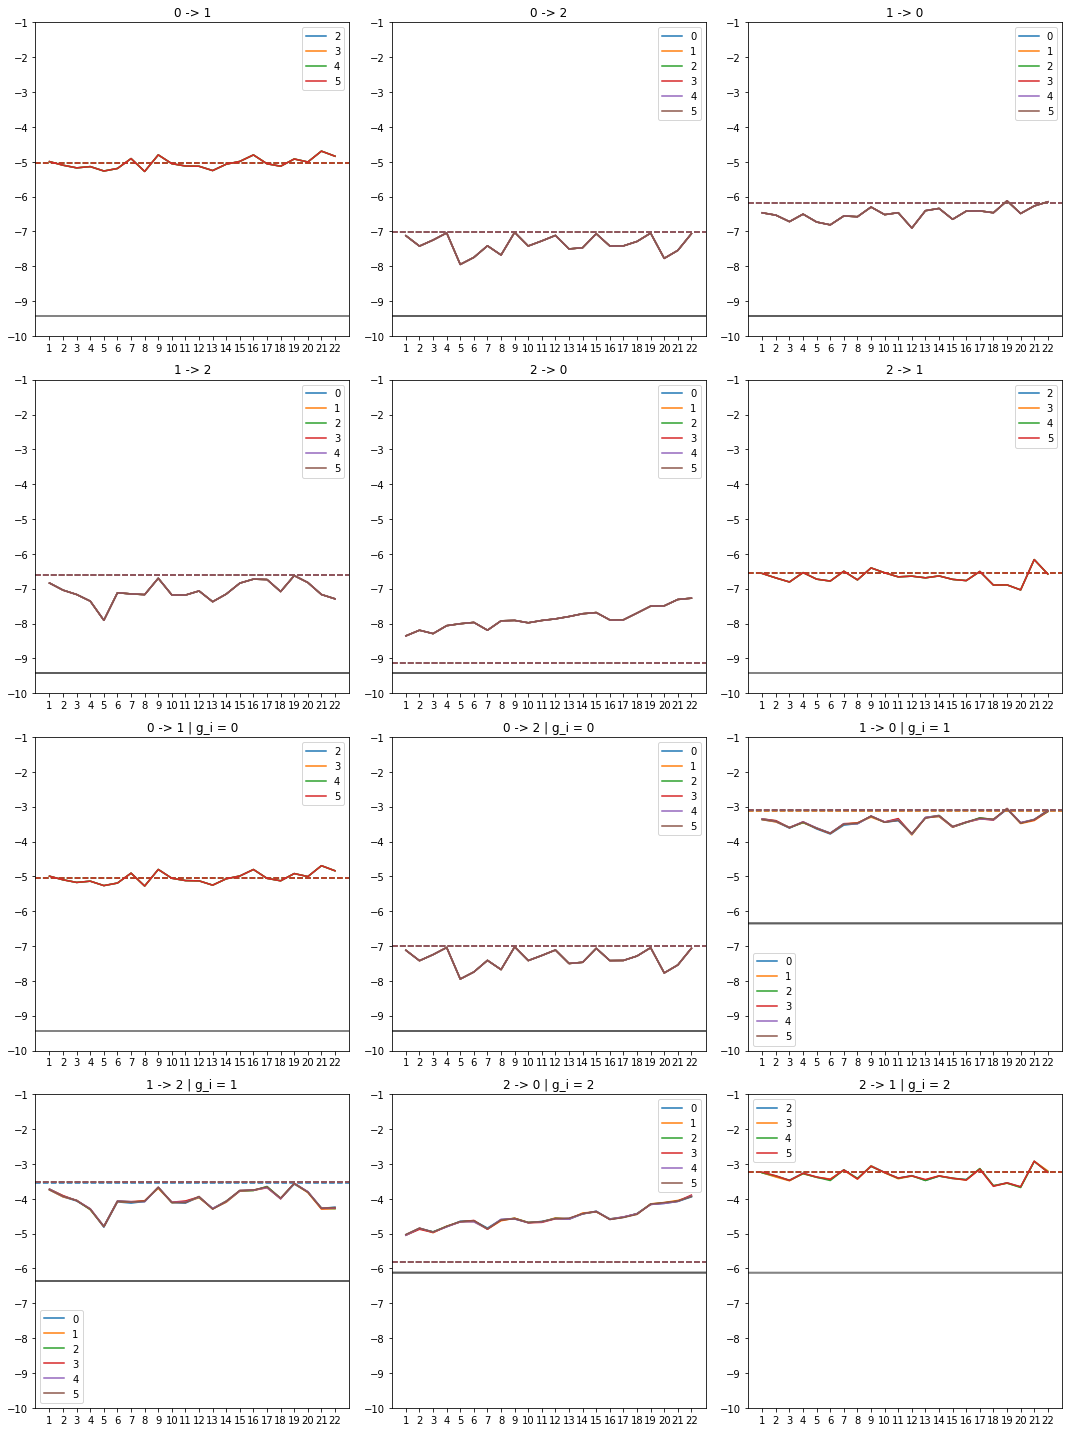

In [119]:
plt.figure(figsize=(15, 20))

ok_chroms = [i for i in range(len(chroms)) if ns_wb[i] is not None and ns_lcl[i] is not None]

ps = np.zeros((len(all_transitions), len(chroms)))
for i, (f, t) in enumerate([(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]):
    
    
    for j, trans in enumerate(all_transitions):
        if len(trans) == 1:
            trans = trans[0]
            if trans[1] == f and trans[2] == t:
                ax1 = plt.subplot(4, 3, i+1)
                norm_factor = [np.sum((genotypes_wb[chrom_i]*is_mendelian)) for chrom_i in ok_chroms]
                p = plt.plot(ok_chroms, np.clip(np.log10([errors_wb[error_type_to_index[(f, t)], trans[0], chrom_i] for chrom_i in ok_chroms]), 0, None)-np.log10(norm_factor), label=str(trans[0]))

                norm_factor = np.sum((genotype_to_counts_genome*is_mendelian))
                plt.axhline(np.clip(np.log10(n_genome_wb[j]), 0, None)-np.log10(norm_factor), linestyle='--', color=p[0].get_color())
                #plt.axhline(np.log10(n_genome_ind[j])-np.log10(norm_factor), linestyle='-', color=p[0].get_color())
                plt.axhline(-np.log10(norm_factor), color='black', alpha=0.2)

                plt.subplot(4, 3, i+7)
                norm_factor = [np.sum((genotypes_wb[chrom_i]*is_mendelian)[tuple(trans[1] if k==trans[0] else slice(None, None, None) for k in range(m))]) for chrom_i in ok_chroms]
                p = plt.plot(ok_chroms, np.clip(np.log10([ns_wb[chrom_i][j] for chrom_i in ok_chroms]), 0, None)-np.log10(norm_factor), label=str(trans[0]))
                ps[j, :] = np.clip(np.log10([ns_wb[chrom_i][j] for chrom_i in ok_chroms]), 0, None)-np.log10(norm_factor)
                
                norm_factor = np.sum((genotype_to_counts_genome*is_mendelian)[tuple(trans[1] if k==trans[0] else slice(None, None, None) for k in range(m))])
                plt.axhline(np.clip(np.log10(n_genome_wb[j]), 0, None)-np.log10(norm_factor), linestyle='--', color=p[0].get_color())
                #plt.axhline(np.log10(n_genome_ind[j])-np.log10(norm_factor), linestyle='-', color=p[0].get_color())
                plt.axhline(-np.log10(norm_factor), color='black', alpha=0.2)
    
    plt.subplot(4, 3, i+1)
    plt.title('%d -> %d' % (f, t))
    plt.xticks(range(len(chroms)), chroms)
    plt.ylim([-10, -1])
    plt.legend()
    
    plt.subplot(4, 3, i+7)
    plt.title('%d -> %d | g_i = %d' % (f, t, f))
    plt.xticks(range(len(chroms)), chroms)
    plt.ylim([-10, -1])
    plt.legend()

plt.tight_layout()            
plt.show()



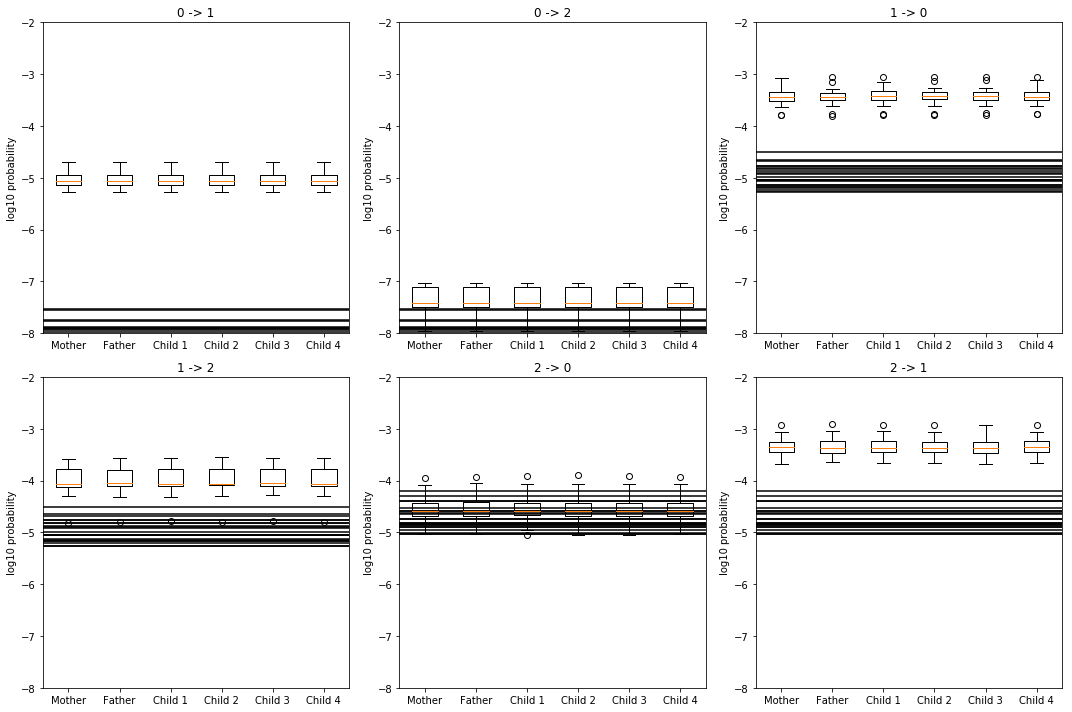

In [121]:
ps[np.isinf(ps)] = np.nan
#print(np.nanstd(ps, axis=1))
#print(np.nanmean(ps, axis=1))

plt.figure(figsize=(15, 10))
for i, (f, t) in enumerate(error_types):
    
    plt.subplot(2, 3, i+1)
    boxes = []
    for j in range(m):
        
        norm_factor = [np.sum((genotypes_wb[chrom_i]*is_mendelian)[tuple(f if k==j else slice(None, None, None) for k in range(m))]) for chrom_i in ok_chroms]
        boxes.append(np.clip(np.log10(errors_wb[i, j, ok_chroms]), 0, None)-np.log10(norm_factor))
        
    
    plt.boxplot(boxes)
    labels = ['Mother', 'Father'] + ['Child %d' % (i-1) for i in range(2, m)]
    plt.xticks(range(1, len(boxes)+1), labels)
    plt.ylabel('log10 probability')
    plt.title('%d -> %d' % (f, t))
    plt.ylim([-8, -2])
    
    norm_factors = [np.sum((genotypes_wb[chrom_i]*is_mendelian)[tuple(f if k==j else slice(None, None, None) for k in range(m))]) for chrom_i in ok_chroms]
    for norm_factor in norm_factors:
        plt.axhline(-np.log10(norm_factor), color='black')
    

plt.tight_layout()
plt.show()

# Now check against LCL/WB error rates

In [67]:
obs_errors = np.zeros((len(chroms), 3, 3), dtype=int)

for i in range(len(chroms)):
    famgens, counts = np.unique(all_gens[i], axis=1, return_counts=True)
    famgen_to_counts = defaultdict(int, [(tuple(fg), c) for (fg, c) in zip(famgens.T, counts)])
    for fg, c in zip(famgens.T, counts):
        if np.all(fg != -1): # skip missing values
            wb, lcl = fg[lcl_wb_index], fg[-1]
            if np.all(fg != -1) and wb != lcl:
                obs_errors[i, wb, lcl] += c

WB 0 LCL 1: slope: 0.362256 intercept: 123.900339
WB 0 LCL 2: slope: 0.937075 intercept: 0.546781
WB 1 LCL 0: slope: 0.352250 intercept: 192.463889
WB 1 LCL 2: slope: 0.348597 intercept: 11.695598
WB 2 LCL 0: slope: 0.744951 intercept: 6.064840
WB 2 LCL 1: slope: 0.303374 intercept: 9.558790


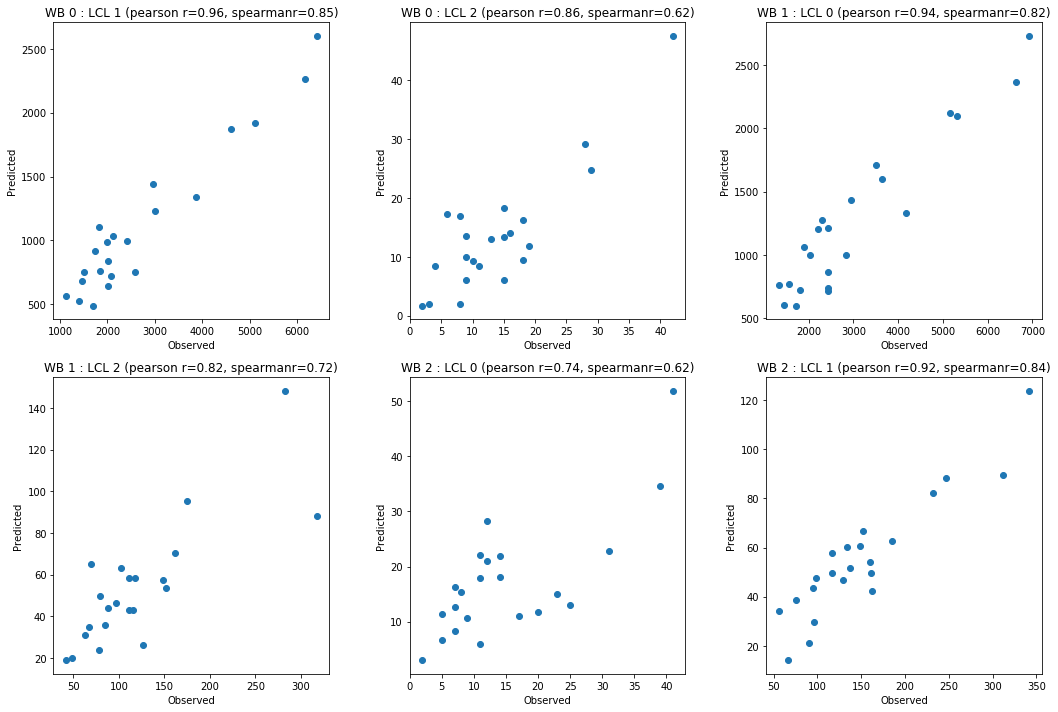

In [68]:
plt.figure(figsize=(15, 10))

all_preds, all_obs = [], []
for index, (wb, lcl) in enumerate([(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]):
    plt.subplot(2, 3, index+1)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    pred = np.zeros((len(chroms),), dtype=int)
    
    # wb could be right and lcl could be wrong
    wb_right_lcl_wrong = errors_lcl[error_type_to_index[(wb, lcl)], lcl_wb_index, ok_chroms]
        
    # lcl could be right and wb could be wrong
    lcl_right_wb_wrong = errors_wb[error_type_to_index[(lcl, wb)], lcl_wb_index, ok_chroms]
        
    pred = wb_right_lcl_wrong + lcl_right_wb_wrong
    obs = [obs_errors[i, wb, lcl] for i in ok_chroms]
    all_preds.append(pred)
    all_obs.append(obs)
    
    plt.scatter(obs, pred)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs, pred)
    print("WB %d LCL %d: slope: %f intercept: %f" % (wb, lcl, slope, intercept))
    #plt.scatter(obs, wb_right_lcl_wrong)
    #plt.scatter(obs, lcl_right_wb_wrong)

    pearsonr = stats.pearsonr(obs, pred)[0]
    spearmanr = stats.spearmanr(obs, pred)[0]
    plt.title('WB %d : LCL %d (pearson r=%0.2f, spearmanr=%0.2f)' % (wb, lcl, pearsonr, spearmanr))
    
    min_value, max_value = min(np.min(obs), np.min(pred)), max(np.max(obs), np.max(pred))
    #plt.plot([0, max_value], [0, max_value], color='black', linestyle='--')

plt.tight_layout()
plt.show()

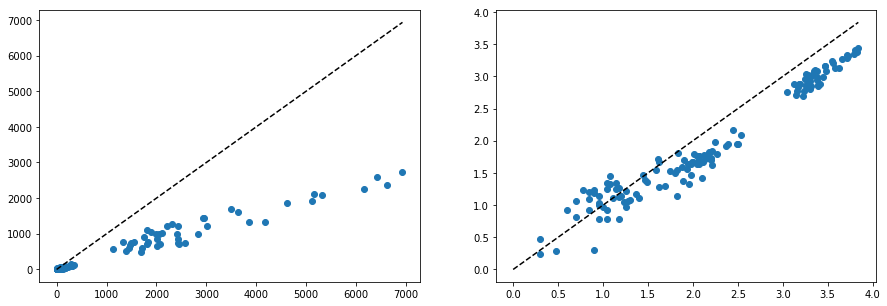

In [69]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(np.hstack(all_obs), np.hstack(all_preds))
plt.plot([0, np.max(all_obs)], [0, np.max(all_obs)], color='black', linestyle='--')

plt.subplot(1, 2, 2)
plt.scatter(np.log10(np.hstack(all_obs)), np.log10(np.hstack(all_preds)))
plt.plot([0, np.log10(np.max(all_obs))], [0, np.log10(np.max(all_obs))], color='black', linestyle='--')

plt.show()

In [ ]:
for j in range(len(sample_ids)):
    trio = np.vstack((lcl_gen[j], wb_gen[j], mom_gen[j], dad_gen[j]))
    trio = trio[:, np.all(trio!=-1, axis=0) & np.any(trio!=0, axis=0)]
    
    famgens, counts = np.unique(trio, axis=1, return_counts=True)
    famgen_to_counts = defaultdict(int, [(tuple(fg), c) for (fg, c) in zip(famgens.T, counts)])
    for fg, c in zip(famgens.T, counts):
        if fg[0] != fg[1]:
            print(tuple(fg), c, 
                  c/famgen_to_counts[(fg[0], fg[0], fg[2], fg[3])],
                  c/famgen_to_counts[(fg[1], fg[1], fg[2], fg[3])])

In [744]:
fgs, xs = [], []
for i, x in enumerate(X_genome[:, transition_to_index[((0, 1, 0),)]]):
    if x != 0:
        fgs.append(nm_genome[i])
        xs.append(x)

indices = np.argsort(xs)[::-1]
has_two = 0
total = 0
for i in indices:
    fg = fgs[i]
    print(fg, tuple(fg[k] if k!=0 else 1 for k in range(m)), xs[i])
    if fg[1] != 0 or np.any([x==2 for x in fg[2:]]):
        total += xs[i]
        
print(total, total/sum(xs))

    


(0, 0, 1, 1, 1, 0) (1, 0, 1, 1, 1, 0) 0.0370702381903
(0, 0, 0, 0, 0, 1) (1, 0, 0, 0, 0, 1) 0.0367617069638
(0, 0, 0, 1, 0, 1) (1, 0, 0, 1, 0, 1) 0.0337550067644
(0, 0, 1, 1, 1, 1) (1, 0, 1, 1, 1, 1) 0.0332829117233
(0, 0, 1, 0, 1, 0) (1, 0, 1, 0, 1, 0) 0.0323543595251
(0, 0, 1, 1, 0, 1) (1, 0, 1, 1, 0, 1) 0.031949465121
(0, 0, 0, 0, 1, 0) (1, 0, 0, 0, 1, 0) 0.0303924390408
(0, 0, 0, 1, 1, 1) (1, 0, 0, 1, 1, 1) 0.0284148806724
(0, 0, 1, 0, 0, 0) (1, 0, 1, 0, 0, 0) 0.0283392271251
(0, 0, 1, 1, 0, 0) (1, 0, 1, 1, 0, 0) 0.0281312855313
(0, 0, 0, 0, 1, 1) (1, 0, 0, 0, 1, 1) 0.0269216740651
(0, 0, 0, 1, 0, 0) (1, 0, 0, 1, 0, 0) 0.0238794716424
(0, 0, 1, 0, 0, 1) (1, 0, 1, 0, 0, 1) 0.0235861556544
(0, 0, 1, 0, 1, 1) (1, 0, 1, 0, 1, 1) 0.0222396070411
(0, 0, 0, 1, 1, 0) (1, 0, 0, 1, 1, 0) 0.0190055235542
(0, 2, 2, 2, 2, 1) (1, 2, 2, 2, 2, 1) 0.0138648861456
(0, 2, 1, 1, 1, 2) (1, 2, 1, 1, 1, 2) 0.0135796004225
(0, 1, 1, 1, 1, 2) (1, 1, 1, 1, 1, 2) 0.0131176488737
(0, 2, 2, 1, 2, 1) (1, 2, 2, 

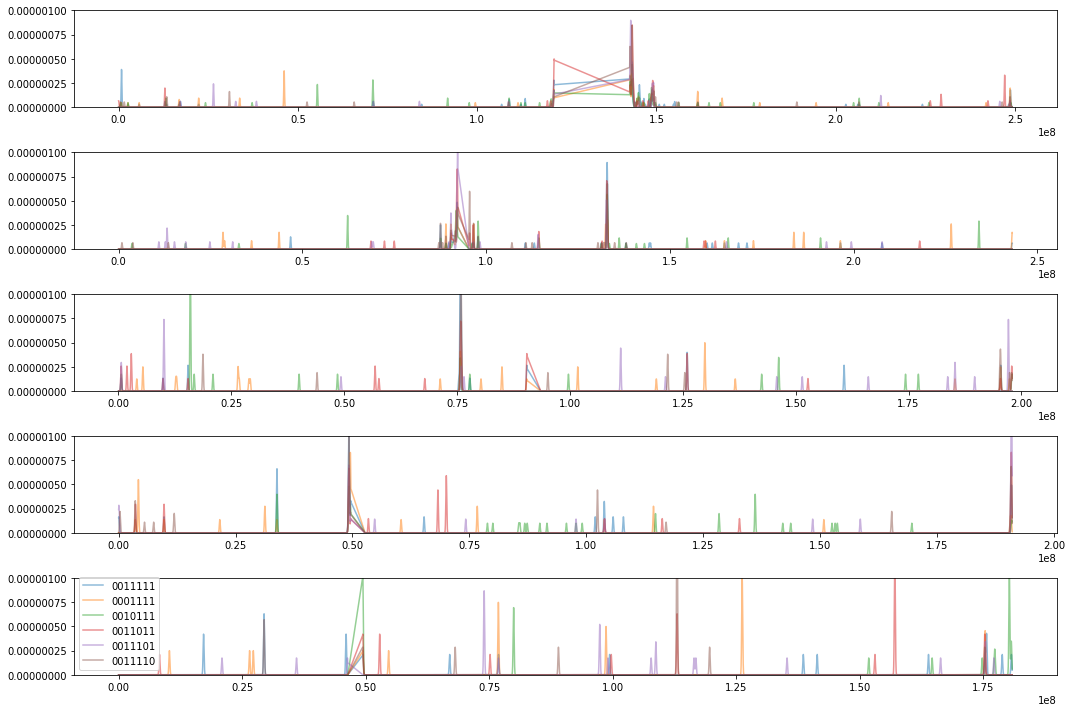

In [20]:
from sklearn.neighbors.kde import KernelDensity

famgens_of_interest = [(0, 0, 1, 1, 1, 1, 1), 
                       (0, 0, 0, 1, 1, 1, 1), (0, 0, 1, 0, 1, 1, 1), (0, 0, 1, 1, 0, 1, 1), (0, 0, 1, 1, 1, 0, 1), (0, 0, 1, 1, 1, 1, 0)]

plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(5, 1, i+1)
    gens_of_interest, pos_of_interest = all_gens[i], all_positions[i]
    
    for fg in famgens_of_interest:
        indices = [tuple(a) == fg for a in gens_of_interest.T]
        d = pos_of_interest[indices, np.newaxis]
        kde = KernelDensity(kernel='gaussian', bandwidth=100000).fit(d)
        log_dens = kde.score_samples(pos_of_interest[:, np.newaxis])

        plt.plot(pos_of_interest, np.exp(log_dens), alpha=0.5, label=''.join(map(str, fg)))
    
    
    plt.ylim([0, pow(10, -6)])

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))

nonmendelian_famgens_set = set(nonmendelian_famgens)
i = 0
gens_of_interest, pos_of_interest = all_gens[i], all_positions[i]

indices = [tuple(fg) in nonmendelian_famgens_set for a in gens_of_interest.T]
print(np.sum(indices))
d = pos_of_interest[indices, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=100000).fit(d)
log_dens = kde.score_samples(pos_of_interest[:, np.newaxis])

plt.plot(pos_of_interest, np.exp(log_dens))
plt.show()

419785


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


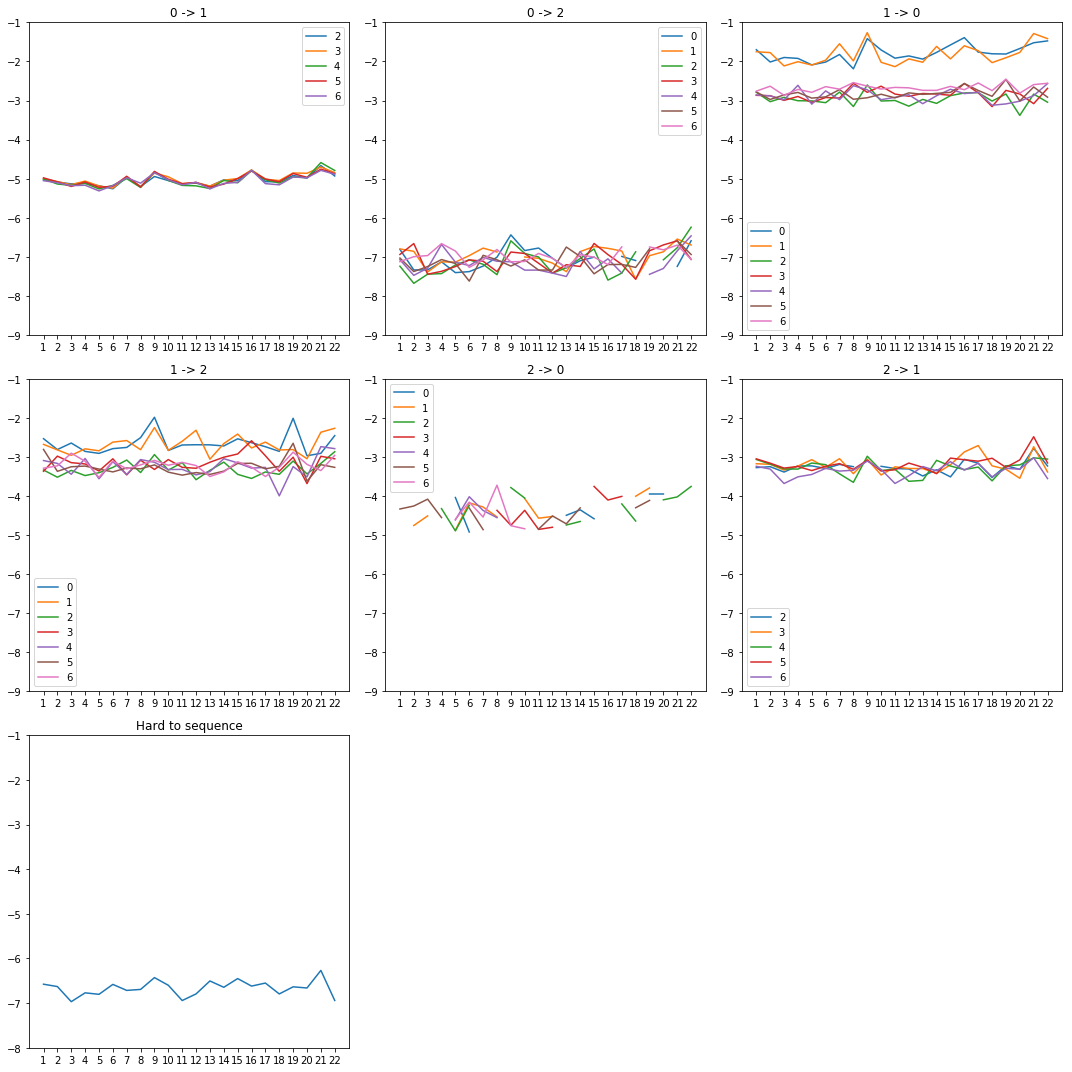

In [335]:
plt.figure(figsize=(15, 15))

for i, (f, t) in enumerate([(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]):
    plt.subplot(3, 3, i+1)
    plt.title('%d -> %d' % (f, t))
    
    for j, trans in enumerate(all_transitions):
        if trans[1] == f and trans[2] == t:
            norm_factor = [np.sum((genotypes[chrom_i]*is_mendelian)[tuple(trans[1] if k==trans[0] else slice(None, None, None) for k in range(m))]) for chrom_i in range(len(chroms))]
            plt.plot(np.log10(np.round(ns[:, j]))-np.log10(norm_factor), label=str(trans[0]))
                        
    plt.xticks(range(len(chroms)), chroms)
    plt.ylim([-9, -1])
    plt.legend()
    
plt.subplot(3, 3, 7)
norm_factor = [np.sum(genotypes[chrom_i]*is_mendelian) for chrom_i in range(len(chroms))]
plt.plot(np.log10(np.round(ns[:, -1]))-np.log10(norm_factor))
plt.xticks(range(len(chroms)), chroms)
plt.ylim([-8, -1])
plt.title('Hard to sequence')

plt.tight_layout()            
plt.show()



(7, 33) (7, 15)


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log10
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: Run

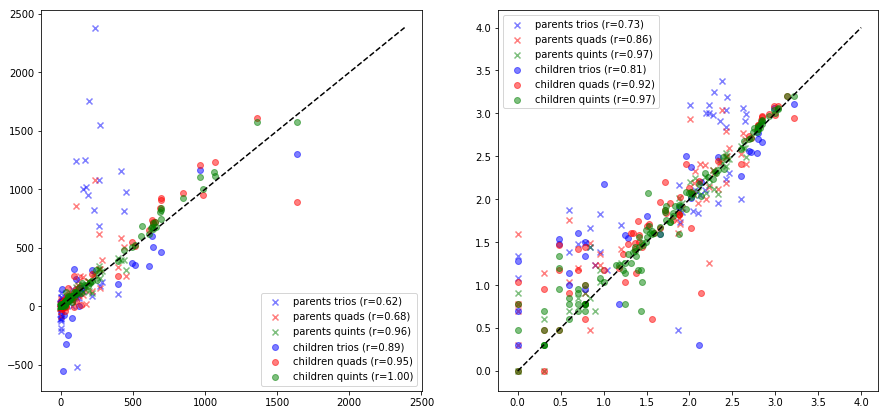

In [242]:
print(ns.shape, ns_trios.shape)

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)

r, p = stats.pearsonr(ns[:, :8].flatten(), ns_trios[:, :8].flatten())
plt.scatter(ns[:, :8], ns_trios[:, :8], alpha=0.5, label='parents trios (r=%0.2f)' % r, color='blue', marker='x')
r, p = stats.pearsonr(ns[:, :8].flatten(), ns_quads[:, :8].flatten())
plt.scatter(ns[:, :8], ns_quads[:, :8], alpha=0.5, label='parents quads (r=%0.2f)' % r, color='red', marker='x')
r, p = stats.pearsonr(ns[:, :8].flatten(), ns_quints[:, :8].flatten())
plt.scatter(ns[:, :8], ns_quints[:, :8], alpha=0.5, label='parents quints (r=%0.2f)' % r, color='green', marker='x')

r, p = stats.pearsonr(ns[:, 8:ns_trios.shape[1]-1].flatten(), ns_trios[:, 8:-1].flatten())
plt.scatter(ns[:, 8:ns_trios.shape[1]-1], ns_trios[:, 8:-1], alpha=0.5, label='children trios (r=%0.2f)' % r, color='blue')
r, p = stats.pearsonr(ns[:, 8:ns_quads.shape[1]-1].flatten(), ns_quads[:, 8:-1].flatten())
plt.scatter(ns[:, 8:ns_quads.shape[1]-1], ns_quads[:, 8:-1], alpha=0.5, label='children quads (r=%0.2f)' % r, color='red')
r, p = stats.pearsonr(ns[:, 8:ns_quints.shape[1]-1].flatten(), ns_quints[:, 8:-1].flatten())
plt.scatter(ns[:, 8:ns_quints.shape[1]-1], ns_quints[:, 8:-1], alpha=0.5, label='children quints (r=%0.2f)' % r, color='green')

max_value = np.max(ns)
max_value = max(max_value, np.max(ns_trios))
max_value = max(max_value, np.max(ns_quads))
max_value = max(max_value, np.max(ns_quints))

plt.plot([0, max_value], [0, max_value], color='black', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)

a, b = np.log10(np.round(ns[:, :8])), np.log10(np.round(ns_trios[:, :8]))
r, p = stats.pearsonr(a[(~np.isinf(a)) & (~np.isinf(b)) & (~np.isnan(a)) & (~np.isnan(b))], b[(~np.isinf(a)) & (~np.isinf(b)) & (~np.isnan(a)) & (~np.isnan(b))])
plt.scatter(a, b, alpha=0.5, label='parents trios (r=%0.2f)' % r, color='blue', marker='x')
a, b = np.log10(np.round(ns[:, :8])), np.log10(np.round(ns_quads[:, :8]))
r, p = stats.pearsonr(a[(~np.isinf(a)) & (~np.isinf(b)) & (~np.isnan(a)) & (~np.isnan(b))], b[(~np.isinf(a)) & (~np.isinf(b)) & (~np.isnan(a)) & (~np.isnan(b))])
plt.scatter(a, b, alpha=0.5, label='parents quads (r=%0.2f)' % r, color='red', marker='x')
a, b = np.log10(np.round(ns[:, :8])), np.log10(np.round(ns_quints[:, :8]))
r, p = stats.pearsonr(a[(~np.isinf(a)) & (~np.isinf(b)) & (~np.isnan(a)) & (~np.isnan(b))], b[(~np.isinf(a)) & (~np.isinf(b)) & (~np.isnan(a)) & (~np.isnan(b))])
plt.scatter(a, b, alpha=0.5, label='parents quints (r=%0.2f)' % r, color='green', marker='x')

a, b = np.log10(np.round(ns[:, 8:ns_trios.shape[1]-1])), np.log10(np.round(ns_trios[:, 8:-1]))
r, p = stats.pearsonr(a[(~np.isinf(a)) & (~np.isinf(b)) & (~np.isnan(a)) & (~np.isnan(b))], b[(~np.isinf(a)) & (~np.isinf(b)) & (~np.isnan(a)) & (~np.isnan(b))])
plt.scatter(a, b, alpha=0.5, label='children trios (r=%0.2f)' % r, color='blue')
a, b = np.log10(np.round(ns[:, 8:ns_quads.shape[1]-1])), np.log10(np.round(ns_quads[:, 8:-1]))
r, p = stats.pearsonr(a[(~np.isinf(a)) & (~np.isinf(b)) & (~np.isnan(a)) & (~np.isnan(b))], b[(~np.isinf(a)) & (~np.isinf(b)) & (~np.isnan(a)) & (~np.isnan(b))])
plt.scatter(a, b, alpha=0.5, label='children quads (r=%0.2f)' % r, color='red')
a, b = np.log10(np.round(ns[:, 8:ns_quints.shape[1]-1])), np.log10(np.round(ns_quints[:, 8:-1]))
r, p = stats.pearsonr(a[(~np.isinf(a)) & (~np.isinf(b)) & (~np.isnan(a)) & (~np.isnan(b))], b[(~np.isinf(a)) & (~np.isinf(b)) & (~np.isnan(a)) & (~np.isnan(b))])
plt.scatter(a, b, alpha=0.5, label='children quints (r=%0.2f)' % r, color='green')

max_value = np.max(np.log10(ns))
#max_value = max(max_value, np.max(ns_trios))
max_value = max(max_value, np.log10(np.max(ns_quads)))
max_value = 4
plt.plot([0, max_value], [0, max_value], color='black', linestyle='--')
plt.legend()

plt.show()

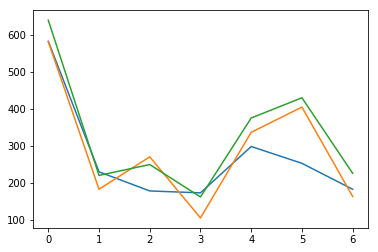

In [259]:
plt.plot(ns_trios[:, -1]/2)
plt.plot(ns_quads[:, -1])
plt.plot(ns_quints[:, -1]*2)
plt.show()

In [68]:
import statsmodels.api as sm

ns_new, expecteds_new, observeds_new = [], [], []
for i in range(len(chroms)):
    chrom = chroms[i]
    X, y, nm, genotype_to_counts = build_X_and_y(chrom, all_gens[i])
    
    n, expected, observed = estimate_family_error(X, y)
    print(np.log(n))
    
    poisson_mod = sm.Poisson(y, X)
    poisson_res = poisson_mod.fit(method='newton')   
    
    
    print(poisson_res.summary())
    
    
    #print('nonzeros', np.sum(n!=0), '/', n.shape[0])
    #ns_new.append(n)
    #expecteds_new.append(expected)
    #observeds_new.append(observed)
    
ns_new = np.asarray(ns_new)


#mod_nbin = sm.NegativeBinomial(y, X)
#res_nbin = mod_nbin.fit(disp=False)
#print(res_nbin.summary())   


            


zeros rows: 60 cols: 0
optimal
[  3.74826462   5.13046479   5.37566695   2.37931603   3.39304239
   5.88121261   5.29495837          nan   6.90483581   2.48531309
   4.60471728   3.62544763   0.31871264   2.47695418   6.97543698
   1.61122252   4.99246304   3.19280985 -14.38670324   3.27556174
   7.00133966   1.09965989   5.2277217    3.50830561 -13.17829703
   3.88145327   5.757696  ]
Optimization terminated successfully.
         Current function value: nan
         Iterations 2
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                  120
Model:                        Poisson   Df Residuals:                       93
Method:                           MLE   Df Model:                           26
Date:                Mon, 11 Feb 2019   Pseudo R-squ.:                     nan
Time:                        11:58:04   Log-Likelihood:                    nan
converged:                       True   

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
//anaconda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:929: RuntimeWarning: overflow encountered in exp
  return stats.poisson.cdf(y, np.exp(X))
//anaconda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1220: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + exposure + offset)
//anaconda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1221: RuntimeWarning: invalid value encountered in multiply
  return -np.dot(L*X.T, X)
//anaconda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1160: RuntimeWarning: overflow encountered in exp
  L = np.exp(np.dot(X,params) + offset + exposure)
//anaconda/lib/python3.6/site-packages/scipy/stats/_discrete_distns.py:462: RuntimeWarning: invalid value encountered in greater_equal
  return mu >= 0
//anaconda/lib/

zeros rows: 60 cols: 0
optimal
[  1.38403953   4.87213351   3.25848176   0.15559712   1.72144404
   4.29822567   3.82756697          nan   6.14531231   2.77838845
   3.66516222   2.98992194 -14.60295595   2.86345898   6.03904939
   2.19751931   3.39636548   4.85242723 -14.424268     2.3512796
   6.32899472   1.95320164   3.95470779   2.92474056 -14.38966189
   2.22998126   4.69767   ]
Optimization terminated successfully.
         Current function value: nan
         Iterations 3
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                  120
Model:                        Poisson   Df Residuals:                       93
Method:                           MLE   Df Model:                           26
Date:                Mon, 11 Feb 2019   Pseudo R-squ.:                     nan
Time:                        11:58:05   Log-Likelihood:                    nan
converged:                       True   L

zeros rows: 58 cols: 0
optimal
[  2.77756558   5.48598929   4.62586831   2.15621463   2.44378081
   5.6491307    4.36714324   1.98784678   6.29486741   2.39809273
   4.79201977   4.42552305 -15.57215958   2.78209989   6.2507251
   0.6937857    4.73050452   0.21981819 -13.69251945          nan
   6.01119611   1.79244302   3.71960638   4.26147103   3.77087233
   2.89255434   4.78413109]
Optimization terminated successfully.
         Current function value: nan
         Iterations 3
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                  122
Model:                        Poisson   Df Residuals:                       95
Method:                           MLE   Df Model:                           26
Date:                Mon, 11 Feb 2019   Pseudo R-squ.:                     nan
Time:                        11:58:05   Log-Likelihood:                    nan
converged:                       True   L

NameError: name 'ns_old' is not defined

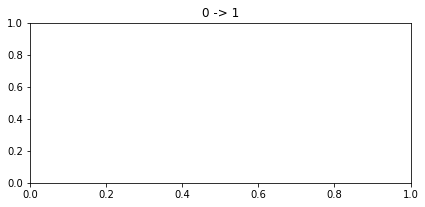

In [181]:
plt.figure(figsize=(15, 10))

for i, (f, t) in enumerate([(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]):
    plt.subplot(3, 2, i+1)
    plt.title('%d -> %d' % (f, t))
    
    for j, trans in enumerate(all_transitions):
        if trans[1] == f and trans[2] == t:
            norm_factor = [np.sum((genotypes[chrom_i]*is_mendelian)[tuple(trans[1] if k==trans[0] else slice(None, None, None) for k in range(m))]) for chrom_i in range(len(chroms))]
            plt.plot(np.log10(ns_old[:, j])-np.log10(norm_factor), label=str(trans[0]))
            
    plt.xticks(range(len(chroms)), chroms)
    plt.ylim([-12, 1])
    plt.legend()
    
plt.tight_layout()            
plt.show()

NameError: name 'y' is not defined

# Solve biconvex problem

In [733]:
all_famgens = list(product(*[[0, 1, 2]]*m))
famgen_to_index = dict([(x, i) for i, x in enumerate(all_famgens)])
q = len(all_famgens)
r = len(chroms)

C = np.zeros((q, r), dtype=int)

for i, A in enumerate(all_gens):
    print(chroms[i], end=' ')
    unique_gens, counts = np.unique(all_gens[i], return_counts=True, axis=1)
    
    for g, c in zip(unique_gens.T, counts):
        if tuple(g) in famgen_to_index:
            C[famgen_to_index[tuple(g)], i] = c
print(C.shape)

16 (243, 1)


In [844]:
all_transitions = [x for x in product(*[list(range(m)), [0, 1, 2], [0, 1, 2], list(range(m)), [0, 1, 2], [0, 1, 2]]) if (x[0] == x[3] and x[1] == x[4] and x[2] == x[5] and x[1] != x[2]) or (x[0] < x[3] and x[1] != x[2] and x[4] != x[5])]#abs(x[1]-x[2])==1]
#all_transitions = [x for x in all_transitions if x[0]==x[3] or x[1]==0 and x[4]==0]
all_transitions = [x for x in all_transitions if x[0]==x[3]]
print(all_transitions)

transition_to_index = dict([(x, i) for i, x in enumerate(all_transitions)])
s = len(all_transitions)
print(q, r, s)


[(0, 0, 1, 0, 0, 1), (0, 0, 2, 0, 0, 2), (0, 1, 0, 0, 1, 0), (0, 1, 2, 0, 1, 2), (0, 2, 0, 0, 2, 0), (0, 2, 1, 0, 2, 1), (1, 0, 1, 1, 0, 1), (1, 0, 2, 1, 0, 2), (1, 1, 0, 1, 1, 0), (1, 1, 2, 1, 1, 2), (1, 2, 0, 1, 2, 0), (1, 2, 1, 1, 2, 1), (2, 0, 1, 2, 0, 1), (2, 0, 2, 2, 0, 2), (2, 1, 0, 2, 1, 0), (2, 1, 2, 2, 1, 2), (2, 2, 0, 2, 2, 0), (2, 2, 1, 2, 2, 1), (3, 0, 1, 3, 0, 1), (3, 0, 2, 3, 0, 2), (3, 1, 0, 3, 1, 0), (3, 1, 2, 3, 1, 2), (3, 2, 0, 3, 2, 0), (3, 2, 1, 3, 2, 1), (4, 0, 1, 4, 0, 1), (4, 0, 2, 4, 0, 2), (4, 1, 0, 4, 1, 0), (4, 1, 2, 4, 1, 2), (4, 2, 0, 4, 2, 0), (4, 2, 1, 4, 2, 1)]
243 1 30


In [845]:
# build graph of neighbors
Edge = namedtuple('Edge', ['from_index', 'to_index', 'transition_index'])

G = []
for i, fg in enumerate(all_famgens):
    for k, (j1, old_g1, new_g1, j2, old_g2, new_g2) in enumerate(all_transitions):
        if old_g1 == fg[j1] and old_g2 == fg[j2]:
            new_fg = tuple(new_g1 if l==j1 else new_g2 if l==j2 else g for l, g in enumerate(fg))
            G.append(Edge(i, famgen_to_index[new_fg], k))
        
print('nodes', len(all_famgens), 'edges', len(G))  

nodes 243 edges 2430


In [846]:
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}
A0 = np.asarray([chrom_lengths[x] for x in chroms])

In [847]:
mendelian_trios = {
    (0, 0, 0), 
    (0, 1, 0), (0, 1, 1),
    (0, 2, 1),
    (1, 0, 0), (1, 0, 1),
    (1, 1, 0), (1, 1, 1), (1, 1, 2),
    (1, 2, 1), (1, 2, 2),
    (2, 0, 1),
    (2, 1, 1), (2, 1, 2),
    (2, 2, 2)
}

is_nonmendelian = []
for famgen in all_famgens:
    is_mend = True
    for j in range(2, m):
        if tuple([famgen[x] for x in [0, 1, j]]) not in mendelian_trios:
            is_mend = False
    is_nonmendelian.append(not is_mend)
print(is_nonmendelian)

[False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, True, False, False, True, True, True, True, False, False, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, True, False, False, True, True, True, True, False, False, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, True, False, False, True, True, True, True, False, F

In [863]:
is_mult_trans = [x[0]!=x[3] or (x[0]==x[3] and abs(x[1]-x[2])==2) for x in all_transitions]
print(is_mult_trans)

[False, True, False, False, True, False, False, True, False, False, True, False, False, True, False, False, True, False, False, True, False, False, True, False, False, True, False, False, True, False]


In [849]:
trans_pairs = []
for trans in all_transitions:
    if trans[1] == 0 and trans[2] == 1:
        trans_pairs.append(transition_to_index[(trans[0], 2, 1, trans[0], 2, 1)])
    elif trans[1] == 0 and trans[2] == 2:
        trans_pairs.append(transition_to_index[(trans[0], 2, 0, trans[0], 2, 0)])
    elif trans[1] == 1 and trans[2] == 0:
        trans_pairs.append(transition_to_index[(trans[0], 1, 2, trans[0], 1, 2)])
    elif trans[1] == 1 and trans[2] == 2:
        trans_pairs.append(transition_to_index[(trans[0], 1, 0, trans[0], 1, 0)])
    elif trans[1] == 2 and trans[2] == 0:
        trans_pairs.append(transition_to_index[(trans[0], 0, 2, trans[0], 0, 2)])
    elif trans[1] == 2 and trans[2] == 1:
        trans_pairs.append(transition_to_index[(trans[0], 0, 1, trans[0], 0, 1)])

In [864]:
# Estimate A, given p

def estimate_A(p):
    # Build X, transition matrix
    X = np.eye(q, dtype=float)

    for e in G:
        X[e.to_index, e.from_index] += p[e.transition_index]
        X[e.to_index, e.to_index] -= p[e.transition_index]

    #print('X', X.shape)

    # cvxpy
    A = cp.Variable(q, r)

    lamb = 1
    #objective = cp.Minimize(cp.sum_squares(X[1:, :]@A - C[1:, :]) + lamb*cp.pnorm(A[is_nonmendelian, :], p=2)**2)#lamb*cp.norm(A[is_nonmendelian, :], 1))    
    objective = cp.Minimize(cp.sum_squares(X[1:, :]@A - C[1:, :]) + lamb*cp.norm(A[is_nonmendelian, :], 1))    
    #objective = cp.Minimize(cp.sum_squares(X[1:, :]@A - C[1:, :]))    

   # prob = cp.Problem(objective, [0 <= A, A[is_nonmendelian, :]==0])#, A[0, :].T <= A0])
    prob = cp.Problem(objective, [0 <= A])
    result = prob.solve(solver='SCS')
    A = A.value
    A[A<1] = 0
    print(np.sum(A==0)/(sum(is_nonmendelian)*A.shape[1]), end=' ')
    #print(A[0, :])
    return A

In [865]:
# Estimate p, given A

def estimate_p(A):
    # Build Y, transition matrix
    Y = np.zeros(((q-1)*r, s))
    d = np.zeros(((q-1)*r,))

    offset = 0
    for j in range(r):
        # for each chromosome
        subY = np.zeros((q, s))
        for e in G:
            subY[e.to_index, e.transition_index] += A[e.from_index, j]
            subY[e.from_index, e.transition_index] -= A[e.from_index, j]

        Y[offset:(offset+q-1), :] = subY[1:, :]
        d[offset:(offset+q-1)] = (C-A)[1:, j].flatten()
        offset += (q-1)

    #print('Y', Y.shape)

    # cvxpy
    p = cp.Variable(s)

    lamb = 100
    objective = cp.Minimize(cp.sum_squares(Y*p - d) + lamb*cp.norm(p[is_mult_trans], 1))
    prob = cp.Problem(objective, [0 <= p, p <= 1])
    result = prob.solve(solver='SCS')
    p = p.value
    p[p<0] = 0
    print(np.sum(p==0)/sum(is_mult_trans))
    #print(p.shape, p)
    return p

In [866]:
ps3 = []

p = pow(10, -5)*np.random.random((s,))
for i in range(10):
    print(i, end=' ')
    A = estimate_A(p)
    p = estimate_p(A)
    ps3.append(p)

0 0.75 1.2
1 0.75 1.2
2 0.7777777777777778 1.1
3 0.7888888888888889 1.2
4 0.7944444444444444 1.2
5 0.8055555555555556 1.2
6 0.8055555555555556 1.0
7 0.8055555555555556 0.8
8 0.8055555555555556 0.8
9 0.8055555555555556 0.8


[[3.56797764e-05]]


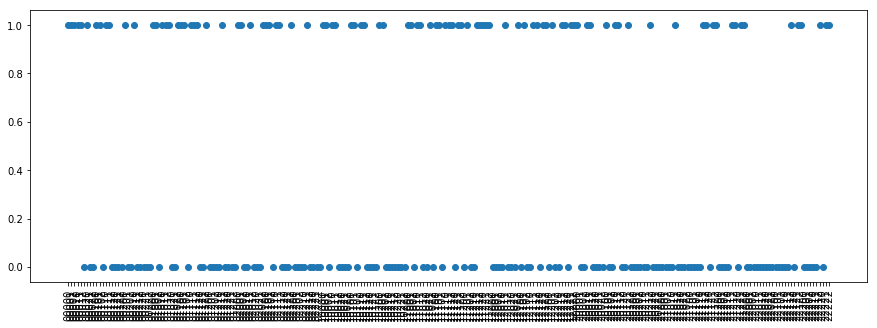

In [867]:
print(A[0, :]/A0)
plt.figure(figsize=(15, 5))
plt.scatter(range(len(all_famgens)), [np.sum(A[i, :]!=0) for i in range(len(all_famgens))])
plt.xticks(range(len(all_famgens)), [''.join(map(str, x)) for x in all_famgens], rotation=90)
plt.show()

In [868]:
#print('M', [str(fg) for fg, c, is_nonmend in zip(all_famgens, [np.sum(A[i, :]!=0) for i in range(len(all_famgens))], is_nonmendelian) if c > 15 and not is_nonmend])
print('NM', [str(fg) for fg, c, is_nonmend in zip(all_famgens, [np.sum(A[i, :]!=0) for i in range(len(all_famgens))], is_nonmendelian) if c > 15 and is_nonmend])

print('M', [str(fg) for fg, c, is_nonmend in zip(all_famgens, [np.sum(A[i, :]!=0) for i in range(len(all_famgens))], is_nonmendelian) if c > 5 and c < 15 and not is_nonmend])
print('NM', [str(fg) for fg, c, is_nonmend in zip(all_famgens, [np.sum(A[i, :]!=0) for i in range(len(all_famgens))], is_nonmendelian) if c > 5 and c < 15 and is_nonmend])

print('M', [str(fg) for fg, c, is_nonmend in zip(all_famgens, [np.sum(A[i, :]!=0) for i in range(len(all_famgens))], is_nonmendelian) if c < 5 and not is_nonmend])
#print('NM', [str(fg) for fg, c, is_nonmend in zip(all_famgens, [np.sum(A[i, :]!=0) for i in range(len(all_famgens))], is_nonmendelian) if c < 5 and is_nonmend])



NM []
M []
NM []
M ['(0, 0, 0, 0, 0)', '(0, 1, 0, 0, 0)', '(0, 1, 0, 0, 1)', '(0, 1, 0, 1, 0)', '(0, 1, 0, 1, 1)', '(0, 1, 1, 0, 0)', '(0, 1, 1, 0, 1)', '(0, 1, 1, 1, 0)', '(0, 1, 1, 1, 1)', '(0, 2, 1, 1, 1)', '(1, 0, 0, 0, 0)', '(1, 0, 0, 0, 1)', '(1, 0, 0, 1, 0)', '(1, 0, 0, 1, 1)', '(1, 0, 1, 0, 0)', '(1, 0, 1, 0, 1)', '(1, 0, 1, 1, 0)', '(1, 0, 1, 1, 1)', '(1, 1, 0, 0, 0)', '(1, 1, 0, 0, 1)', '(1, 1, 0, 0, 2)', '(1, 1, 0, 1, 0)', '(1, 1, 0, 1, 1)', '(1, 1, 0, 1, 2)', '(1, 1, 0, 2, 0)', '(1, 1, 0, 2, 1)', '(1, 1, 0, 2, 2)', '(1, 1, 1, 0, 0)', '(1, 1, 1, 0, 1)', '(1, 1, 1, 0, 2)', '(1, 1, 1, 1, 0)', '(1, 1, 1, 1, 1)', '(1, 1, 1, 1, 2)', '(1, 1, 1, 2, 0)', '(1, 1, 1, 2, 1)', '(1, 1, 1, 2, 2)', '(1, 1, 2, 0, 0)', '(1, 1, 2, 0, 1)', '(1, 1, 2, 0, 2)', '(1, 1, 2, 1, 0)', '(1, 1, 2, 1, 1)', '(1, 1, 2, 1, 2)', '(1, 1, 2, 2, 0)', '(1, 1, 2, 2, 1)', '(1, 1, 2, 2, 2)', '(1, 2, 1, 1, 1)', '(1, 2, 1, 1, 2)', '(1, 2, 1, 2, 1)', '(1, 2, 1, 2, 2)', '(1, 2, 2, 1, 1)', '(1, 2, 2, 1, 2)', '(1, 2, 2, 

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


-6.0 -2.0


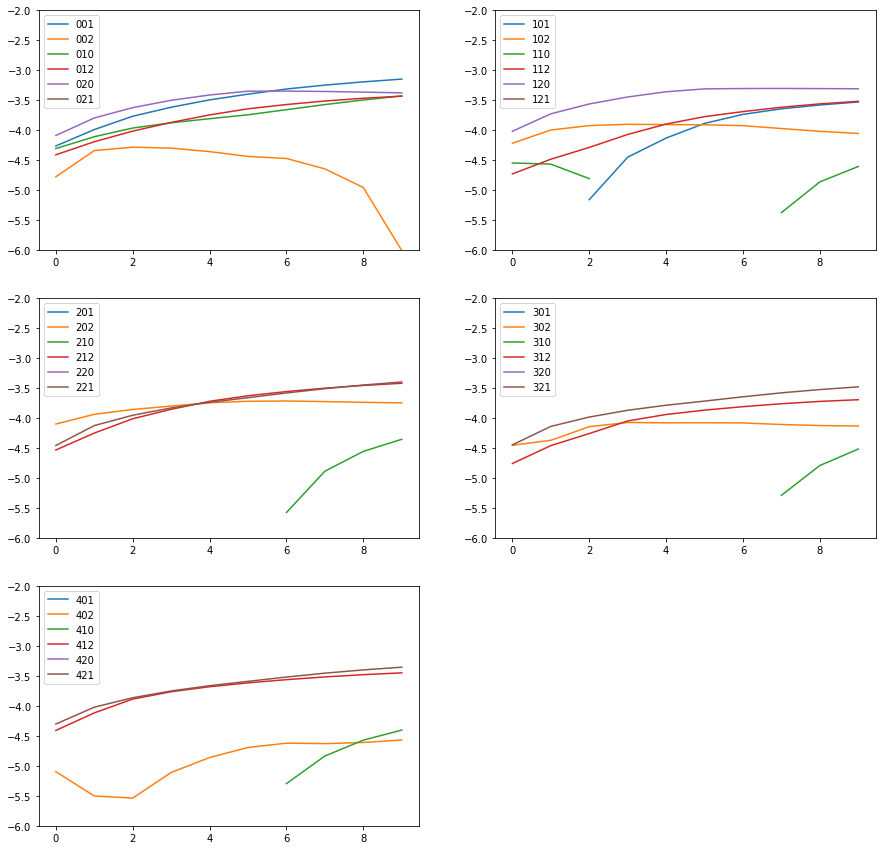

In [869]:
plt.figure(figsize=(15, 15))

min_p, max_p = np.floor(np.min(np.log10(all_ps[all_ps != 0]))), np.ceil(np.max(np.log10(all_ps)))
print(min_p, max_p)

all_ps = np.hstack(ps3)
for i, t in enumerate(all_transitions):
    if t[0] == t[3]:
        plt.subplot(3, 2, t[0]+1)
        plt.plot(np.log10(all_ps[i, :].T), label=''.join(map(str, t[:3])))
    else:
        plt.subplot(3, 2, 6)
        if all_ps[i, -1]>pow(10, -9):
            plt.plot(np.log10(all_ps[i, :].T), label=''.join(map(str, t)))

for i in range(m):
    plt.subplot(3, 2, i+1)
    plt.ylim([min_p, max_p])
    plt.legend()
plt.show()

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


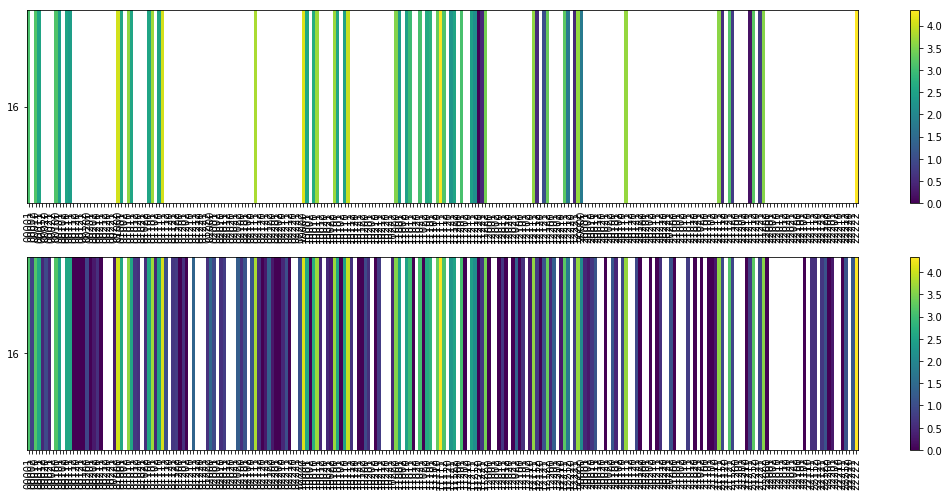

In [856]:
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.imshow(np.log10(A.T[:, 1:]), aspect='auto', vmin=0)
#plt.imshow(A.T, aspect='auto', vmin=0)
plt.yticks(range(len(chroms)), chroms)
plt.xticks(range(len(all_famgens)-1), [''.join(map(str, x)) for x in all_famgens[1:]], rotation=90)
plt.colorbar()

plt.subplot(2, 1, 2)
plt.imshow(np.log10(C.T[:, 1:]), aspect='auto', vmin=0)
#plt.imshow(C.T, aspect='auto', vmin=0)
plt.yticks(range(len(chroms)), chroms)
plt.xticks(range(len(all_famgens)-1), [''.join(map(str, x)) for x in all_famgens[1:]], rotation=90)
plt.colorbar()

plt.tight_layout()
plt.show()

TypeError: Image data cannot be converted to float

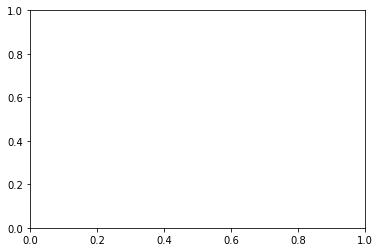

In [102]:




ps = []
for A, chrom in zip(all_gens, chroms):
    print(chrom)
    if A is not None:
        famgens, counts = np.unique(A, axis=1, return_counts=True)
        gen_to_count = defaultdict(int)
        gen_to_count.update([(tuple(f), c) for f, c in zip(famgens.T, counts)])
        gen_to_index = dict([(tuple(x), i) for i, x in enumerate(famgens.T)])
        
        # non mendelian
        ok_trios = set([(0, 0, 0), 
                        (0, 1, 0), (0, 1, 1), 
                        (0, 2, 1), 
                        (1, 0, 0), (1, 0, 1),
                        (1, 1, 0), (1, 1, 1), (1, 1, 2),
                        (1, 2, 1), (1, 2, 2),
                        (2, 0, 1),
                        (2, 1, 1), (2, 1, 2),
                        (2, 2, 2)])

        n = counts.shape[0]
        is_missing, is_nonmendel, is_mendel = np.zeros((n,), dtype=bool), np.zeros((n,), dtype=bool), np.zeros((n,), dtype=bool)
        for i, (fg, c) in enumerate(zip(famgens.T, counts)):
            if np.any(fg==-1):
                is_missing[i] = True
            else:
                is_mend = True
                for j in range(2, m):
                    is_mend = is_mend & (tuple(fg[[0, 1, j]]) in ok_trios)

                if is_mend:
                    is_mendel[i] = True
                else:
                    is_nonmendel[i] = True
        print('Missing', np.sum(is_missing)/n, np.sum(counts[is_missing])/np.sum(counts), '\n',
              'Non-mendelian', np.sum(is_nonmendel)/n, np.sum(counts[is_nonmendel])/np.sum(counts), '\n',
              'Mendelian', np.sum(is_mendel)/n, np.sum(counts[is_mendel])/np.sum(counts))


        
        # create graph where nodes are observed family genotypes and edges exist between one-hop neighbors where 
        # one is mendelian, and one is non-mendelian
        n = counts.shape[0]
        neighbors = [[] for _ in range(n)]
        has_homref_neighbor = np.zeros((n,), dtype=bool)

        for i, fg in enumerate(famgens.T):
            for j in range(m):
                for newg in range(0, 3):
                    #if fg[j] != newg:
                    if abs(fg[j]-newg) == 1:
                        neighbor = tuple(newg if k==j else x for k, x in enumerate(fg))
                        if neighbor == (0,)*m:
                            has_homref_neighbor[i] = True
                        if (neighbor in gen_to_index):
                            neighbors[i].append(gen_to_index[neighbor])


        p = np.zeros((2,), dtype=float)
        p[:] = 1/pow(10, 5)

        fgs = [fg for fg in product(*([[2], [2]] + [[2, 1]]*(m-2))) if fg in gen_to_index \
               and is_nonmendel[gen_to_index[fg]]]
        #fgs = [tuple(x) for x in famgens[:, is_nonmendel & (~has_homref_neighbor)].T]
        #print(fgs)
        n = len(fgs)

        obs = np.asarray([counts[gen_to_index[fg]] for fg in fgs])
        #print(obs)

        A = np.zeros((n, 2), dtype=int)
        for i, fg in enumerate(fgs):
            index = gen_to_index[fg]
            for neighbor in neighbors[index]:
                nfg = famgens[:, neighbor]
                no_match = [j for j, (a, b) in enumerate(zip(fg, nfg)) if a!=b][0]
                if (fg[no_match] == 1 and nfg[no_match] == 0) or (fg[no_match] == 1 and nfg[no_match] == 2):
                    A[i, 0] += counts[neighbor]
                elif (fg[no_match] == 0 and nfg[no_match] == 1) or (fg[no_match] == 2 and nfg[no_match] == 1):
                    A[i, 1] += counts[neighbor]
                else:
                    print('?')
        print('A', A)

        # Estimate p
        p = cp.Variable(2)
        constraints = [0 <= p, p <= 1]

        objective = cp.Minimize(cp.sum_squares(A*p - obs))
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        p = p.value.A1
        print(p)
        print('after p', (A.dot(p)).astype(int), obs)
        ps.append(p)


In [44]:
from itertools import product
from collections import defaultdict

all_famgens = list(product(*[[0, 1, 2]]*4))

mendelian_trios = {
    (0, 0, 0), 
    (0, 1, 0), (0, 1, 1),
    (0, 2, 1),
    (1, 0, 0), (1, 0, 1),
    (1, 1, 0), (1, 1, 1), (1, 1, 2),
    (1, 2, 1), (1, 2, 2),
    (2, 0, 1),
    (2, 1, 1), (2, 1, 2),
    (2, 2, 2)
}

mendelian_fam_gens = set()
for famgen in all_famgens:
    is_mend = True
    for j in range(2, m):
        if tuple([famgen[x] for x in [0, 1, j]]) not in mendelian_trios:
            is_mend = False
    if is_mend:
        mendelian_fam_gens.add(famgen)
    
print('Mendelian', len(mendelian_fam_gens))

one_step_famgen_to_neighbors = defaultdict(list)
for famgen in all_famgens:
    if famgen not in mendelian_fam_gens:
        for j in range(m):
            for g in [0, 1, 2]:
                if abs(g-famgen[j]) == 1:
                    neighbor = tuple([famgen[x] if x != j else g for x in range(m)])
                    if neighbor in mendelian_fam_gens:
                        one_step_famgen_to_neighbors[famgen].append(neighbor)

print(one_step_famgen_to_neighbors)

Mendelian 29
defaultdict(<class 'list'>, {(0, 0, 0, 1): [(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 0, 0)], (0, 0, 1, 0): [(1, 0, 1, 0), (0, 1, 1, 0), (0, 0, 0, 0)], (0, 0, 1, 1): [(1, 0, 1, 1), (0, 1, 1, 1)], (0, 1, 0, 2): [(1, 1, 0, 2), (0, 1, 0, 1)], (0, 1, 1, 2): [(1, 1, 1, 2), (0, 1, 1, 1)], (0, 1, 2, 0): [(1, 1, 2, 0), (0, 1, 1, 0)], (0, 1, 2, 1): [(1, 1, 2, 1), (0, 1, 1, 1)], (0, 1, 2, 2): [(1, 1, 2, 2)], (0, 2, 0, 0): [(0, 1, 0, 0)], (0, 2, 0, 1): [(0, 1, 0, 1), (0, 2, 1, 1)], (0, 2, 1, 0): [(0, 1, 1, 0), (0, 2, 1, 1)], (0, 2, 1, 2): [(1, 2, 1, 2), (0, 2, 1, 1)], (0, 2, 2, 1): [(1, 2, 2, 1), (0, 2, 1, 1)], (0, 2, 2, 2): [(1, 2, 2, 2)], (1, 0, 0, 2): [(1, 1, 0, 2), (1, 0, 0, 1)], (1, 0, 1, 2): [(1, 1, 1, 2), (1, 0, 1, 1)], (1, 0, 2, 0): [(1, 1, 2, 0), (1, 0, 1, 0)], (1, 0, 2, 1): [(1, 1, 2, 1), (1, 0, 1, 1)], (1, 0, 2, 2): [(1, 1, 2, 2)], (1, 2, 0, 0): [(1, 1, 0, 0)], (1, 2, 0, 1): [(1, 1, 0, 1), (1, 2, 1, 1)], (1, 2, 0, 2): [(1, 1, 0, 2), (1, 2, 1, 2)], (1, 2, 1, 0): [(1, 1, 1, 0), (1,

In [35]:

print(all_gens[0].shape)

(4, 400145)


In [31]:
A = np.hstack([x for x in all_gens if x is not None])
plt.figure(figsize=(15, 5))
plt.imshow(A, aspect='auto')
plt.show()

NameError: name 'all_gens' is not defined

In [402]:
from collections import defaultdict

famgens, counts = np.unique(A, axis=1, return_counts=True)
gen_to_count = defaultdict(int)
gen_to_count.update([(tuple(f), c) for f, c in zip(famgens.T, counts)])
gen_to_index = dict([(tuple(x), i) for i, x in enumerate(famgens.T)])
print(len(gen_to_count), pow(3, m))
print(famgens.shape)

989 243
(5, 989)


Let $s$ be a vector of observed counts, while $x$ is a vector of actual counts. Then 
\begin{align*}
s[i] = (1-p)x[i] + p\sum_{n \in N} \frac{x[n]}{d[n]}
\end{align*}

In [403]:
# non mendelian
ok_trios = set([(0, 0, 0), 
                (0, 1, 0), (0, 1, 1), 
                (0, 2, 1), 
                (1, 0, 0), (1, 0, 1),
                (1, 1, 0), (1, 1, 1), (1, 1, 2),
                (1, 2, 1), (1, 2, 2),
                (2, 0, 1),
                (2, 1, 1), (2, 1, 2),
                (2, 2, 2)])

n = counts.shape[0]
is_missing, is_nonmendel, is_mendel = np.zeros((n,), dtype=bool), np.zeros((n,), dtype=bool), np.zeros((n,), dtype=bool)
for i, (fg, c) in enumerate(zip(famgens.T, counts)):
    if np.any(fg==-1):
        is_missing[i] = True
    else:
        is_mend = True
        for j in range(2, m):
            is_mend = is_mend & (tuple(fg[[0, 1, j]]) in ok_trios)
        
        if is_mend:
            is_mendel[i] = True
        else:
            is_nonmendel[i] = True
print('Missing', np.sum(is_missing)/n, np.sum(counts[is_missing])/np.sum(counts), '\n',
      'Non-mendelian', np.sum(is_nonmendel)/n, np.sum(counts[is_nonmendel])/np.sum(counts), '\n',
      'Mendelian', np.sum(is_mendel)/n, np.sum(counts[is_mendel])/np.sum(counts))



Missing 0.7553083923154702 0.009136129216528718 
 Non-mendelian 0.1820020222446916 0.025548382945776202 
 Mendelian 0.06268958543983821 0.965315487837695


In [404]:
# create graph where nodes are observed family genotypes and edges exist between one-hop neighbors where 
# one is mendelian, and one is non-mendelian
n = counts.shape[0]
neighbors = [[] for _ in range(n)]
has_homref_neighbor = np.zeros((n,), dtype=bool)

for i, fg in enumerate(famgens.T):
    for j in range(m):
        for newg in range(0, 3):
            #if fg[j] != newg:
            if abs(fg[j]-newg) == 1:
                neighbor = tuple(newg if k==j else x for k, x in enumerate(fg))
                if neighbor == (0,)*m:
                    has_homref_neighbor[i] = True
                if (neighbor in gen_to_index):
                    neighbors[i].append(gen_to_index[neighbor])
       

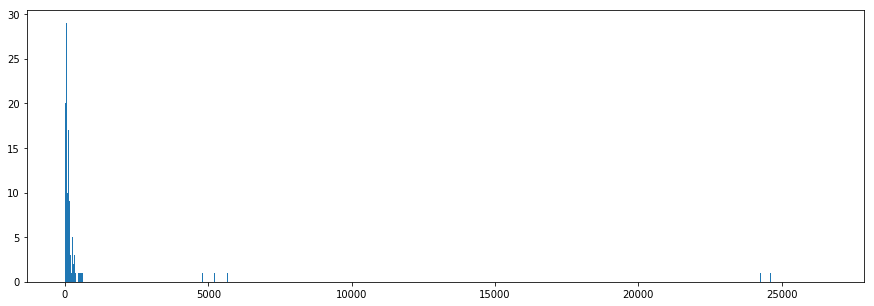

In [405]:
plt.figure(figsize=(15, 5))
plt.hist(counts[is_nonmendel], bins=range(0, max(counts[is_nonmendel]), 20))
plt.show()

In [473]:
from collections import Counter

nonmendel_c = Counter(dict([(tuple(x), c) for x, c in zip(famgens[:, is_nonmendel].T, counts[is_nonmendel])]))
f = []
labels = []
cs = []
print('Non-mendel')
for fg, c in nonmendel_c.items():
    index = gen_to_index[fg]
    print('famgen', fg, c, '%0.4f' % (c/sum([counts[i] for i in neighbors[index]])))
    print([tuple(famgens[:, i]) for i in neighbors[index]], (0,)*m if has_homref_neighbor[index] else '')
    print(sum([counts[i] for i in neighbors[index]]), [counts[i] for i in neighbors[index]])
    f.append(c/sum([counts[i] for i in neighbors[index]]))
    cs.append(c)
    labels.append(str(fg))
    
    #fg = tuple(2 if x == 0 else 0 if x == 2 else 1 for x in fg)
    #c = nonmendel_c[fg]
    #index = gen_to_index[fg]
    #print('famgen', fg, c, '%0.4f' % (c/sum([counts[i] for i in neighbors[index]])))
    #print([tuple(famgens[:, i]) for i in neighbors[index]], (0,)*m if has_homref_neighbor[index] else '')
    #print(sum([counts[i] for i in neighbors[index]]), [counts[i] for i in neighbors[index]])

#print('\nMendel')
#mendel_c = Counter(dict([(tuple(x), c) for x, c in zip(famgens[:, is_mendel].T, counts[is_mendel])]))
#for fg, c in mendel_c.most_common(20):
#    index = gen_to_index[fg]
#    print(fg, c, [tuple(famgens[:, i]) for i in neighbors[index]], (0,)*m if has_homref_neighbor[index] else '')
#    print(sum([counts[i] for i in neighbors[index]]), [counts[i] for i in neighbors[index]])

#print('\nMissing')
#missing_c = Counter(dict([(tuple(x), c) for x, c in zip(famgens[:, is_missing].T, counts[is_missing])]))
#for fg, c in missing_c.most_common(20):
#    index = gen_to_index[fg]
#    print(fg, c, [tuple(famgens[:, i]) for i in neighbors[index]], (0,)*m if has_homref_neighbor[index] else '')

Non-mendel
famgen (0, 0, 0, 0, 1) 655 0.2718
[(1, 0, 0, 0, 1), (0, 1, 0, 0, 1), (0, 0, 1, 0, 1), (0, 0, 0, 1, 1), (0, 0, 0, 0, 2)] (0, 0, 0, 0, 0)
2410 [1845, 222, 185, 157, 1]
famgen (0, 0, 0, 0, 2) 1 0.0015
[(1, 0, 0, 0, 2), (0, 0, 1, 0, 2), (0, 0, 0, 0, 1)] 
660 [2, 3, 655]
famgen (0, 0, 0, 1, 0) 766 0.0958
[(1, 0, 0, 1, 0), (0, 1, 0, 1, 0), (0, 0, 1, 1, 0), (0, 0, 0, 2, 0), (0, 0, 0, 1, 1)] (0, 0, 0, 0, 0)
7996 [4245, 3289, 296, 9, 157]
famgen (0, 0, 0, 1, 1) 157 0.0634
[(1, 0, 0, 1, 1), (0, 1, 0, 1, 1), (0, 0, 1, 1, 1), (0, 0, 0, 0, 1), (0, 0, 0, 2, 1), (0, 0, 0, 1, 0)] 
2478 [417, 106, 533, 655, 1, 766]
famgen (0, 0, 0, 2, 0) 9 0.0115
[(1, 0, 0, 2, 0), (0, 1, 0, 2, 0), (0, 0, 1, 2, 0), (0, 0, 0, 1, 0), (0, 0, 0, 2, 1)] 
784 [7, 9, 1, 766, 1]
famgen (0, 0, 0, 2, 1) 1 0.0058
[(1, 0, 0, 2, 1), (0, 0, 0, 1, 1), (0, 0, 0, 2, 0), (0, 0, 0, 2, 2)] 
171 [3, 157, 9, 2]
famgen (0, 0, 0, 2, 2) 2 2.0000
[(0, 0, 0, 2, 1)] 
1 [1]
famgen (0, 0, 1, 0, 0) 682 0.4617
[(1, 0, 1, 0, 0), (0, 1, 1, 0,

[('(0, 0, 0, 2, 2)', 2.0)]
[('(2, 2, 1, 0, 0)', 1.0)]
[('(0, 0, 1, 0, 0)', 0.4617467840216655), ('(2, 0, 2, 2, 0)', 0.5)]
[('(0, 0, 0, 0, 1)', 0.2717842323651452), ('(0, 0, 2, 0, 2)', 0.23529411764705882), ('(0, 1, 2, 2, 0)', 0.3333333333333333), ('(0, 2, 0, 2, 2)', 0.3333333333333333), ('(0, 2, 1, 2, 0)', 0.2413793103448276), ('(1, 2, 0, 0, 2)', 0.3333333333333333)]


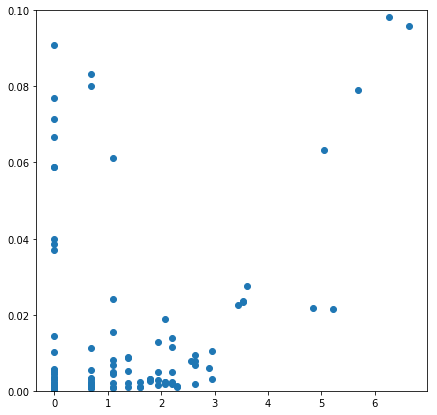

In [478]:
print([(labels[i], x) for i, x in enumerate(f) if x > 1.75])
print([(labels[i], x) for i, x in enumerate(f) if x > .75 and x <= 1.75])
print([(labels[i], x) for i, x in enumerate(f) if x > .4 and x <= .75])
print([(labels[i], x) for i, x in enumerate(f) if x > .2 and x <= .4])

plt.figure(figsize=(7, 7))
plt.scatter(np.log(cs), f)
plt.ylim([0, 0.1])
plt.show()

In [479]:
#EM

ps = []
for A, chrom in zip(all_gens, chroms):
    print(chrom)
    if A is not None:
        famgens, counts = np.unique(A, axis=1, return_counts=True)
        gen_to_count = defaultdict(int)
        gen_to_count.update([(tuple(f), c) for f, c in zip(famgens.T, counts)])
        gen_to_index = dict([(tuple(x), i) for i, x in enumerate(famgens.T)])
        
        # non mendelian
        ok_trios = set([(0, 0, 0), 
                        (0, 1, 0), (0, 1, 1), 
                        (0, 2, 1), 
                        (1, 0, 0), (1, 0, 1),
                        (1, 1, 0), (1, 1, 1), (1, 1, 2),
                        (1, 2, 1), (1, 2, 2),
                        (2, 0, 1),
                        (2, 1, 1), (2, 1, 2),
                        (2, 2, 2)])

        n = counts.shape[0]
        is_missing, is_nonmendel, is_mendel = np.zeros((n,), dtype=bool), np.zeros((n,), dtype=bool), np.zeros((n,), dtype=bool)
        for i, (fg, c) in enumerate(zip(famgens.T, counts)):
            if np.any(fg==-1):
                is_missing[i] = True
            else:
                is_mend = True
                for j in range(2, m):
                    is_mend = is_mend & (tuple(fg[[0, 1, j]]) in ok_trios)

                if is_mend:
                    is_mendel[i] = True
                else:
                    is_nonmendel[i] = True
        print('Missing', np.sum(is_missing)/n, np.sum(counts[is_missing])/np.sum(counts), '\n',
              'Non-mendelian', np.sum(is_nonmendel)/n, np.sum(counts[is_nonmendel])/np.sum(counts), '\n',
              'Mendelian', np.sum(is_mendel)/n, np.sum(counts[is_mendel])/np.sum(counts))


        
        # create graph where nodes are observed family genotypes and edges exist between one-hop neighbors where 
        # one is mendelian, and one is non-mendelian
        n = counts.shape[0]
        neighbors = [[] for _ in range(n)]
        has_homref_neighbor = np.zeros((n,), dtype=bool)

        for i, fg in enumerate(famgens.T):
            for j in range(m):
                for newg in range(0, 3):
                    #if fg[j] != newg:
                    if abs(fg[j]-newg) == 1:
                        neighbor = tuple(newg if k==j else x for k, x in enumerate(fg))
                        if neighbor == (0,)*m:
                            has_homref_neighbor[i] = True
                        if (neighbor in gen_to_index):
                            neighbors[i].append(gen_to_index[neighbor])


        p = np.zeros((2,), dtype=float)
        p[:] = 1/pow(10, 5)

        fgs = [fg for fg in product(*([[2], [2]] + [[2, 1]]*(m-2))) if fg in gen_to_index \
               and is_nonmendel[gen_to_index[fg]]]
        #fgs = [tuple(x) for x in famgens[:, is_nonmendel & (~has_homref_neighbor)].T]
        #print(fgs)
        n = len(fgs)

        obs = np.asarray([counts[gen_to_index[fg]] for fg in fgs])
        #print(obs)

        A = np.zeros((n, 2), dtype=int)
        for i, fg in enumerate(fgs):
            index = gen_to_index[fg]
            for neighbor in neighbors[index]:
                nfg = famgens[:, neighbor]
                no_match = [j for j, (a, b) in enumerate(zip(fg, nfg)) if a!=b][0]
                if (fg[no_match] == 1 and nfg[no_match] == 0) or (fg[no_match] == 1 and nfg[no_match] == 2):
                    A[i, 0] += counts[neighbor]
                elif (fg[no_match] == 0 and nfg[no_match] == 1) or (fg[no_match] == 2 and nfg[no_match] == 1):
                    A[i, 1] += counts[neighbor]
                else:
                    print('?')
        print('A', A)

        # Estimate p
        p = cp.Variable(2)
        constraints = [0 <= p, p <= 1]

        objective = cp.Minimize(cp.sum_squares(A*p - obs))
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        p = p.value.A1
        print(p)
        print('after p', (A.dot(p)).astype(int), obs)
        ps.append(p)


1
Missing 0.7122207621550591 0.009068847230536504 
 Non-mendelian 0.2076215505913272 0.030405850164063917 
 Mendelian 0.08015768725361366 0.9605253026053996
A [[62630  6622]
 [62629  8470]
 [  118  2993]
 [62629  3482]
 [  121  9148]
 [  114  6502]
 [   41 11220]]
[0.00080176 0.00125902]
after p [58 60  3 54 11  8 14] [61 54 13 59 14 12 10]
2
3
Missing 0.678125 0.007140802657916517 
 Non-mendelian 0.225 0.017882823918900673 
 Mendelian 0.096875 0.9749763734231828
A [[51507  6745]
 [51504  3829]
 [   56  7561]
 [51504  4324]
 [   54  3640]
 [   64  7808]
 [   11 10234]]
[0.00052234 0.00035542]
after p [29 28  2 28  1  2  3] [23 32  2 31  1  8  2]
4
Missing 0.6802413273001509 0.007166204301370616 
 Non-mendelian 0.2277526395173454 0.019251792237756474 
 Mendelian 0.09200603318250378 0.9735820034608729
A [[60608   833]
 [60611  7711]
 [   78  3553]
 [60608  3312]
 [   76  8163]
 [   67   945]
 [   34 16814]]
[0.00054935 0.00077078]
after p [33 39  2 35  6  0 12] [42 34 13 33  8 11 12]
5
M

//anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


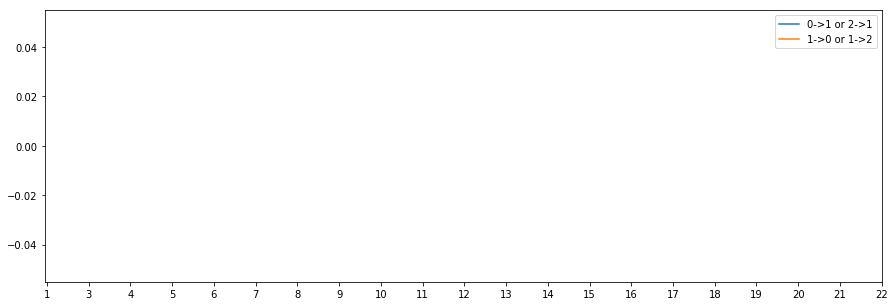

In [456]:
plt.figure(figsize=(15, 5))
plt.plot([x[0] for x in ps], label='0->1 or 2->1')
plt.plot([x[1] for x in ps], label='1->0 or 1->2')
plt.axhline(np.median([x[0] for x in ps]), color='black', linestyle='--')
plt.axhline(np.median([x[1] for x in ps]), color='black', linestyle='--')
plt.legend()
plt.xticks(range(len(chroms)-1), [x for x, a in zip(chroms, all_gens) if a is not None])
plt.show()

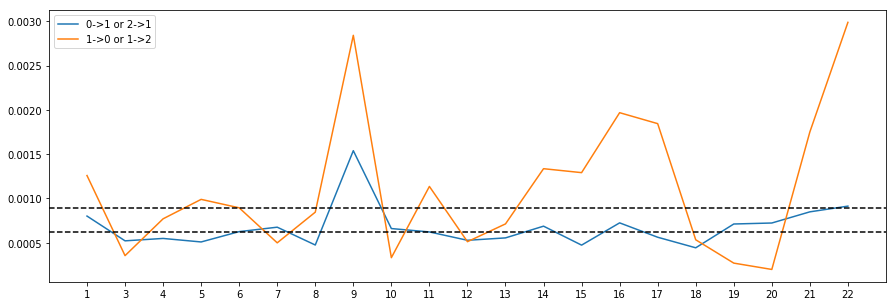

In [454]:
plt.figure(figsize=(15, 5))
plt.plot([x[0] for x in ps], label='0->1 or 2->1')
plt.plot([x[1] for x in ps], label='1->0 or 1->2')
plt.axhline(np.median([x[0] for x in ps]), color='black', linestyle='--')
plt.axhline(np.median([x[1] for x in ps]), color='black', linestyle='--')
plt.legend()
plt.xticks(range(len(chroms)-1), [x for x, a in zip(chroms, all_gens) if a is not None])
plt.show()

In [398]:
print(p)

[0.00088844 0.00216436]


In [457]:
#EM

ps = []
for A, chrom in zip(all_gens, chroms):
    print(chrom)
    try:
        if A is not None:
            famgens, counts = np.unique(A, axis=1, return_counts=True)
            gen_to_count = defaultdict(int)
            gen_to_count.update([(tuple(f), c) for f, c in zip(famgens.T, counts)])
            gen_to_index = dict([(tuple(x), i) for i, x in enumerate(famgens.T)])

            # non mendelian
            ok_trios = set([(0, 0, 0), 
                            (0, 1, 0), (0, 1, 1), 
                            (0, 2, 1), 
                            (1, 0, 0), (1, 0, 1),
                            (1, 1, 0), (1, 1, 1), (1, 1, 2),
                            (1, 2, 1), (1, 2, 2),
                            (2, 0, 1),
                            (2, 1, 1), (2, 1, 2),
                            (2, 2, 2)])

            n = counts.shape[0]
            is_missing, is_nonmendel, is_mendel = np.zeros((n,), dtype=bool), np.zeros((n,), dtype=bool), np.zeros((n,), dtype=bool)
            for i, (fg, c) in enumerate(zip(famgens.T, counts)):
                if np.any(fg==-1):
                    is_missing[i] = True
                else:
                    is_mend = True
                    for j in range(2, m):
                        is_mend = is_mend & (tuple(fg[[0, 1, j]]) in ok_trios)

                    if is_mend:
                        is_mendel[i] = True
                    else:
                        is_nonmendel[i] = True
            print('Missing', np.sum(is_missing)/n, np.sum(counts[is_missing])/np.sum(counts), '\n',
                  'Non-mendelian', np.sum(is_nonmendel)/n, np.sum(counts[is_nonmendel])/np.sum(counts), '\n',
                  'Mendelian', np.sum(is_mendel)/n, np.sum(counts[is_mendel])/np.sum(counts))



            # create graph where nodes are observed family genotypes and edges exist between one-hop neighbors where 
            # one is mendelian, and one is non-mendelian
            n = counts.shape[0]
            neighbors = [[] for _ in range(n)]
            has_homref_neighbor = np.zeros((n,), dtype=bool)

            for i, fg in enumerate(famgens.T):
                for j in range(m):
                    for newg in range(0, 3):
                        #if fg[j] != newg:
                        if abs(fg[j]-newg) == 1:
                            neighbor = tuple(newg if k==j else x for k, x in enumerate(fg))
                            if neighbor == (0,)*m:
                                has_homref_neighbor[i] = True
                            if (neighbor in gen_to_index):
                                neighbors[i].append(gen_to_index[neighbor])


            fgs = [fg for fg in product(*([[2], [2]] + [[2, 1]]*(m-2))) if fg in gen_to_index and is_nonmendel[gen_to_index[fg]]]
            #fgs = [tuple(x) for x in famgens[:, is_nonmendel & (~has_homref_neighbor)].T]

            #print(fgs)
            n = len(fgs)

            obs = np.asarray([counts[gen_to_index[fg]] for fg in fgs])
            #print(obs)

            A = np.zeros((n, m), dtype=int)
            for i, fg in enumerate(fgs):
                index = gen_to_index[fg]
                for neighbor in neighbors[index]:
                    nfg = famgens[:, neighbor]
                    no_match = [j for j, (a, b) in enumerate(zip(fg, nfg)) if a!=b][0]
                    A[i, no_match] += counts[neighbor]
    
            print('A', A)

            # Estimate p
            p = cp.Variable(m)
            constraints = [0 <= p, p <= 1]

            objective = cp.Minimize(cp.sum_squares(A*p - obs))
            prob = cp.Problem(objective, constraints)
            result = prob.solve()
            p = p.value.A1
            print(p)
            print('after p', (A.dot(p)).astype(int), obs)
            ps.append(p)
    except:
        pass


1
Missing 0.7122207621550591 0.009068847230536504 
 Non-mendelian 0.2076215505913272 0.030405850164063917 
 Mendelian 0.08015768725361366 0.9605253026053996
A [[ 5322  1273    14    13 62630]
 [ 5525  2920    12 62629    13]
 [ 2844   139    10    64    54]
 [ 3347   109 62629    12    14]
 [ 5909  3229    61    10    60]
 [ 5109  1383    54    60    10]
 [  471 10749    14    15    12]]
[0.00231266 0.00076    0.00081682 0.00062254 0.00076175]
after p [61 54  6 58 16 12  9] [61 54 13 59 14 12 10]
2
3
Missing 0.678125 0.007140802657916517 
 Non-mendelian 0.225 0.017882823918900673 
 Mendelian 0.096875 0.9749763734231828
A [[ 3704  3038     1     2 51507]
 [ 1104  2715     8 51504     2]
 [ 7545    14     2    23    33]
 [ 4300    15 51504     8     1]
 [ 1950  1688    23     2    31]
 [ 4956  2850    33    31     2]
 [ 2529  7705     2     1     8]]
[0.00055908 0.0002708  0.00055509 0.00059498 0.00039029]
after p [22 32  4 31  1  3  3] [23 32  2 31  1  8  2]
4
Missing 0.6802413273001509

Missing 0.6507633587786259 0.011050172292482275 
 Non-mendelian 0.23473282442748092 0.031517797542802505 
 Mendelian 0.11450381679389313 0.9574320301647152
A [[   10     1     1     4 13324]
 [ 1341  3171     2 13324     4]
 [  619   720     2    10     9]
 [  417   720 13324     2     1]
 [ 1474  3412    10     2    12]
 [    2     5     9    11     2]
 [ 2171   134     4     1     2]]
[1.13405466e-03 9.76224049e-09 7.90032541e-04 5.61286818e-04
 7.49583267e-04]
after p [10  9  0 11  1  0  2] [10  9  4 11  1  2  2]
20
Missing 0.6 0.005329491007568919 
 Non-mendelian 0.24691358024691357 0.029555239219498645 
 Mendelian 0.15308641975308643 0.9651152697729324
A [[  810   939     1     1 13170]
 [  502  1073     1 13170     1]
 [ 2436  1111     1    16     6]
 [ 2608  1170 13170     1     1]
 [  351  1620    16     1     8]
 [ 1093   469     6     8     1]
 [  446   518     1     1     1]]
[0.00023685 0.00062519 0.00050489 0.00039549 0.00115566]
after p [15  5  1  8  1  0  0] [16  6  1  8

0.0008112487727597026
0.00075999730520846
0.0005311299855705919
0.0005949814291229412
0.0006675578154911387


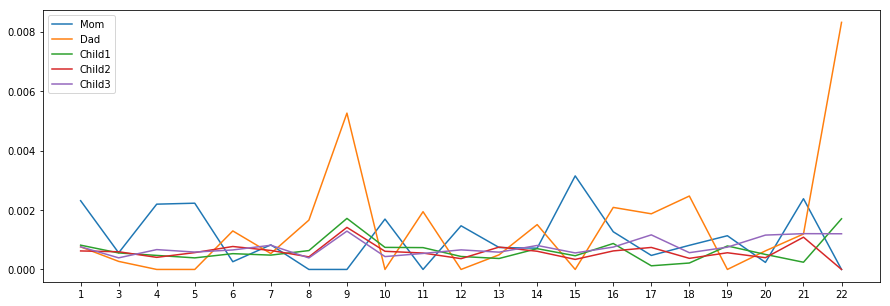

In [458]:
plt.figure(figsize=(15, 5))

labels = ['Mom', 'Dad', 'Child1', 'Child2', 'Child3']
for i in range(m):
    plt.plot([x[i] for x in ps], label=labels[i])
    #plt.axhline(np.median([x[i] for x in ps]), color='black', linestyle='--')
    print(np.median([x[i] for x in ps]))
    
plt.legend()
#plt.ylim([0, 0.005])
plt.xticks(range(len(chroms)-1), [x for x, a in zip(chroms, all_gens) if a is not None])
plt.show()

0.007922480395991235
0.006641239131975797
4.559068893591328e-07
6.736590924727042e-07
0.00015540521154958528


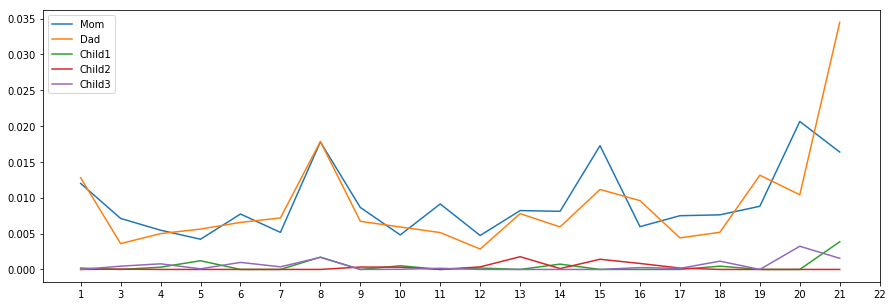

In [445]:
plt.figure(figsize=(15, 5))

labels = ['Mom', 'Dad', 'Child1', 'Child2', 'Child3']
for i in range(m):
    plt.plot([x[i] for x in ps], label=labels[i])
    #plt.axhline(np.median([x[i] for x in ps]), color='black', linestyle='--')
    print(np.median([x[i] for x in ps]))
    
plt.legend()
#plt.ylim([0, 0.005])
plt.xticks(range(len(chroms)-1), [x for x, a in zip(chroms, all_gens) if a is not None])
plt.show()

In [462]:

#EM

n0 = 90354753
#n0 = 100000
p = np.zeros((3,), dtype=float)
p[:] = 1/pow(10, 5)

fgs = [fg for fg in product(*([[0], [0]] + [[0, 1]]*(m-2))) if fg in gen_to_index and is_nonmendel[gen_to_index[fg]]]
print(fgs)
n = len(fgs)

obs = np.asarray([counts[gen_to_index[fg]] for fg in fgs])
print(obs)

A = np.zeros((n, 3), dtype=int)
B = np.zeros((n, 3), dtype=int)
for i, fg in enumerate(fgs):
    index = gen_to_index[fg]
    for neighbor in neighbors[index]:
        nfg = famgens[:, neighbor]
        no_match = [j for j, (a, b) in enumerate(zip(fg, nfg)) if a!=b][0]
        if (fg[no_match] == 1 and nfg[no_match] == 0) or (fg[no_match] == 1 and nfg[no_match] == 2):
            A[i, 0] += counts[neighbor]
        elif (fg[no_match] == 0 and nfg[no_match] == 1) or (fg[no_match] == 2 and nfg[no_match] == 1):
            A[i, 1] += counts[neighbor]
        else:
            print('?')
    if has_homref_neighbor[index]:
        no_match = [j for j, (a, b) in enumerate(zip(fg, (0,)*m)) if a!=b][0]
        B[i, 0] += 1
    B[i, -1] = 1
print('A', A)
print('B', B)

for _ in range(5):
    print(n0, p)
    
    # Estimate n
    c, d = A.dot(p) - obs, B.dot(p)
    n0 = -c.dot(d)/(2*d.dot(d))
    
    # Estimate p
    p = cp.Variable(3)
    constraints = [0 <= p, p <= 1]
    
    objective = cp.Minimize(cp.sum_squares((A + (n0*B))*p - obs))
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    p = p.value.A1
    print('after p', ((A + (n0*B)).dot(p)).astype(int), obs)


[(0, 0, 0, 0, 1), (0, 0, 0, 1, 0), (0, 0, 0, 1, 1), (0, 0, 1, 0, 0), (0, 0, 1, 0, 1), (0, 0, 1, 1, 0), (0, 0, 1, 1, 1)]
[655 766 157 682 185 296 533]
A [[   1 2409    0]
 [   9 7987    0]
 [1422 1056    0]
 [   3 1474    0]
 [1341 7294    0]
 [1450 2296    0]
 [ 645 4779    0]]
B [[1 0 1]
 [1 0 1]
 [0 0 1]
 [1 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]
90354753 [1.e-05 1.e-05 1.e-05]


SolverError: Solver 'ECOS' failed. Try another solver.

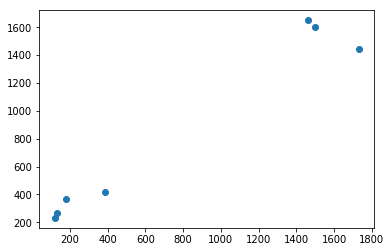

In [323]:
plt.scatter(((A + (n0*B)).dot(p)).astype(int), obs)
plt.show()

In [337]:

#EM

n0 = 90354753
p = np.zeros((2*m,), dtype=float)
p[:] = 1/pow(10, 3)

fgs = [tuple(fg) for fg in famgens[:, is_nonmendel].T]
print(fgs)
n = len(fgs)

obs = np.asarray([counts[gen_to_index[fg]] for fg in fgs])
print(obs)

A = np.zeros((n, 2*m), dtype=int)
B = np.zeros((n, 2*m), dtype=int)
for i, fg in enumerate(fgs):
    index = gen_to_index[fg]
    for neighbor in neighbors[index]:
        nfg = famgens[:, neighbor]
        no_match = [j for j, (a, b) in enumerate(zip(fg, nfg)) if a!=b][0]
        if (fg[no_match] == 1 and nfg[no_match] == 0) or (fg[no_match] == 1 and nfg[no_match] == 2):
            A[i, no_match] += counts[neighbor]
        elif (fg[no_match] == 0 and nfg[no_match] == 1) or (fg[no_match] == 2 and nfg[no_match] == 1):
            A[i, m+no_match] += counts[neighbor]
    if has_homref_neighbor[index]:
        no_match = [j for j, (a, b) in enumerate(zip(fg, (0,)*m)) if a!=b][0]
        B[i, no_match] += 1
print('A', A)
print('B', B)

for _ in range(10):
    print(n0, p)
    
    # Estimate n
    c, d = A.dot(p) - obs, B.dot(p)
    n0 = -c.dot(d)/(2*d.dot(d))
    
    # Estimate p
    p = cp.Variable(2*m)
    constraints = [0 <= p, p <= 1]
    Z = A+(n0*B)
    objective = cp.Minimize(cp.sum_squares(Z*p - obs))
    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver='SCS')
    p = p.value.A1


[(0, 0, 0, 0, 1), (0, 0, 0, 0, 2), (0, 0, 0, 1, 0), (0, 0, 0, 1, 1), (0, 0, 0, 1, 2), (0, 0, 0, 2, 0), (0, 0, 0, 2, 1), (0, 0, 0, 2, 2), (0, 0, 1, 0, 0), (0, 0, 1, 0, 1), (0, 0, 1, 0, 2), (0, 0, 1, 1, 0), (0, 0, 1, 1, 1), (0, 0, 1, 1, 2), (0, 0, 1, 2, 0), (0, 0, 1, 2, 1), (0, 0, 2, 0, 0), (0, 0, 2, 0, 1), (0, 0, 2, 0, 2), (0, 0, 2, 1, 0), (0, 0, 2, 1, 1), (0, 0, 2, 2, 0), (0, 1, 0, 0, 2), (0, 1, 0, 1, 2), (0, 1, 0, 2, 0), (0, 1, 0, 2, 1), (0, 1, 0, 2, 2), (0, 1, 1, 0, 2), (0, 1, 1, 1, 2), (0, 1, 1, 2, 0), (0, 1, 1, 2, 1), (0, 1, 1, 2, 2), (0, 1, 2, 0, 0), (0, 1, 2, 0, 1), (0, 1, 2, 1, 0), (0, 1, 2, 1, 1), (0, 1, 2, 1, 2), (0, 2, 0, 0, 0), (0, 2, 0, 0, 1), (0, 2, 0, 0, 2), (0, 2, 0, 1, 0), (0, 2, 0, 1, 1), (0, 2, 0, 2, 1), (0, 2, 0, 2, 2), (0, 2, 1, 0, 0), (0, 2, 1, 0, 1), (0, 2, 1, 0, 2), (0, 2, 1, 1, 0), (0, 2, 1, 1, 2), (0, 2, 1, 2, 1), (0, 2, 1, 2, 2), (0, 2, 2, 0, 0), (0, 2, 2, 0, 1), (0, 2, 2, 1, 0), (0, 2, 2, 1, 1), (0, 2, 2, 1, 2), (0, 2, 2, 2, 1), (0, 2, 2, 2, 2), (1, 0, 0, 0, 

In [208]:
import cvxpy as cp
import numpy as np

p = cp.Variable(m,)
n = cp.Variable()
constraints = [0 <= p, p <= 1, 0 <= n]

A = np.zeros((pow(2, m-2)-1, m), dtype=int)
observed = np.zeros((pow(2, m-2)-1,), dtype=int)
for i, fg in enumerate(product(*([[0], [0]] + [[0, 1]]*(m-2)))):
    if fg != (0,)*m:
        print(fg)
        observed[i] = counts[gen_to_index[fg]]

objective = cp.Minimize(cp.sum_squares(A*p - observed))
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print(p.value)

(0, 0, 0, 0, 1)
(0, 0, 0, 1, 0)
(0, 0, 0, 1, 1)
(0, 0, 1, 0, 0)
(0, 0, 1, 0, 1)
(0, 0, 1, 1, 0)
(0, 0, 1, 1, 1)
None


## resolve missing values
Family genotypes with missing values may represent a set of genotypes that perfectly match the present values. We use the observed proportions of all genotypes in this set to distribute the missing genotypes.

In [60]:
missing_indices = np.where(np.any(famgens==-1, axis=0))[0]

complete_famgens_to_index = dict([(x, i) for i, x in enumerate(product(*[[0, 1, 2]]*m))])
print(len(complete_famgens_to_index))
complete_indices = np.where(np.all(famgens!=-1, axis=0))[0]
complete_famgens, complete_counts = famgens[:, complete_indices].copy(), counts[complete_indices].copy()
print(complete_famgens.shape, complete_counts.shape)

for i in missing_indices:
    fg = famgens[:, i]
    c = counts[i]
    
    

243
(5, 182) (182,)
